# VT vs SKAN Performance Analysis (Campaign-Level)

**Objective**: Identify pre-configuration for iOS campaigns for the SKAN primary customer (Netmarble).
The customer is conservative about running iOS campaigns. If we can achieve reasonable iOS performance — at least during the launch phase — we may be able to sustain or even scale up iOS spend.

**Analysis doc**: [Google Doc](https://docs.google.com/document/d/1qREdnrd2lKxNmxPrzjdnI3-zPLH1TBOunjrhl1ID3C8/edit?tab=t.0#heading=h.1fqgfrlvf367)

---

### Table of Contents

| # | Section | What it does |
|---|---------|-------------|
| **Setup** | Environment Setup | Imports, BQ client |
| **Config** | Configuration | Filters, thresholds, target countries |
| **Step 1** | Data Pull | Campaign-level MMP + SKAN query |
| **Step 2** | Data Cleaning & Discrepancy | Country grouping, numeric conversion, discrepancy metrics |
| **Step 3** | Outlier Removal | IQR-based outlier removal, analysis dataset prep |
| **Step 4** | VT vs SKAN Performance | Pearson + Spearman correlation by geo (ROAS, CPI) |
| **Step 5** | VT vs MMP-SKAN Discrepancy | Correlation between VT ratio and MMP-SKAN gaps |
| **Step 6** | Scatter Plots — Performance | VT vs SKAN ROAS/CPI scatter by geo |
| **Step 7** | Scatter Plots — Discrepancy | VT vs Install/CPI discrepancy scatter by geo |
| **Step 8** | Overall Correlation Summary | Pooled correlations + combined results table |
| **Step 9** | VT Bucket Analysis | SKAN performance by VT ratio bucket (avg + median) |
| **Step 9b** | VT Bucket Charts by Country | Bar charts with sample counts |
| **Step 9c** | VT Bucket Charts (Clean) | External-sharing version with color-coded reliability |
| **Step 9d** | VT Bucket Mean vs Median | Side-by-side mean vs median bars per country |
| **Step 10** | High VT Campaigns | Detail on campaigns with VT ≥ 50% |
| **Step 11** | Export to Excel | Multi-sheet Excel export |
| **Step 12** | Summary & VT Knob Recommendations | Key findings + per-country knob recommendation with confidence levels |

**Tip**: Use **Cmd+F** (or Ctrl+F) and search for "Step 4", "Step 9b", etc. to jump to any section.


---
## Environment Setup

In [54]:
# # ONLY FOR COLAB
# # Colab authentication
# from google.colab import auth
# auth.authenticate_user()

# # Install dependencies
# !pip install google-api-python-client pandas matplotlib numpy scipy


In [55]:
# CAMPAIGN-LEVEL VT Ratio vs SKAN Performance & Discrepancy Analysis
# Analyzing top spending iOS Gaming CAMPAIGNS (single-geo only)
#
# UNIT OF ANALYSIS: Individual Campaign
# - Campaigns are the minimum unit of performance
# - VT knob adjustments are made at campaign level
# - Single-geo campaigns ensure accurate geo attribution for SKAN
#
# PART 1 - VT Ratio vs SKAN Performance (per geo):
# - VT Ratio: MMP-based installs_vt / installs
# - SKAN ROAS: SKAN_Revenue / SKAN_Spend
# - SKAN CPI: SKAN_Spend / SKAN_Installs
#
# PART 2 - VT Ratio vs MMP-SKAN Discrepancy (per geo):
# - Install Discrepancy: (SKAN_Installs - MMP_Installs) / MMP_Installs
# - CPI Discrepancy: (SKAN_CPI - MMP_CPI) / MMP_CPI
# - ROAS Discrepancy: (SKAN_ROAS - MMP_ROAS) / MMP_ROAS

from pathlib import Path
import os
from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Output folder: vt_skan_performance (notebook and outputs live here)
try:
    OUTPUT_DIR = Path(__file__).resolve().parent
except NameError:
    OUTPUT_DIR = Path(os.getcwd()) / 'iOS Measurement' / 'vt_skan_performance'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
print(f'Outputs will be saved to: {OUTPUT_DIR.resolve()}')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

client = bigquery.Client(project='moloco-ods')

def process_query(input_query):
    job_config = bigquery.QueryJobConfig()
    query_job = client.query(input_query, job_config=job_config)
    df_return = query_job.result().to_dataframe()
    return df_return

print('Environment ready - Campaign-Level Analysis')

Outputs will be saved to: /Users/haewon.yum/Documents/Queries/iOS Measurement/vt_skan_performance/iOS Measurement/vt_skan_performance
Environment ready - Campaign-Level Analysis


---
## Configuration - Campaign Level Analysis

In [56]:
# Analysis parameters for CAMPAIGN-LEVEL analysis

# Filters (campaign.os, not platform_id)
CAMPAIGN_OS = 'IOS'
LOOKBACK_MONTHS = 6

# Campaign-level thresholds (lower than bundle-level since individual campaigns)
MIN_CAMPAIGN_SPEND = 500      # Minimum spend per campaign
MIN_CAMPAIGN_INSTALLS = 50     # Minimum installs per campaign
TOP_N_CAMPAIGNS = 5000         # Number of top campaigns to analyze

# Target countries for geo-level analysis
TARGET_COUNTRIES = ['USA', 'JPN', 'KOR', 'GBR', 'DEU', 'FRA', 'CAN', 'AUS', 'TWN', 'HKG', 'MAC', 'BRA']

# Country grouping: combine small geos that customers typically treat as one
COUNTRY_GROUP = {
    'TWN': 'TWN+HKG+MAC', 'HKG': 'TWN+HKG+MAC', 'MAC': 'TWN+HKG+MAC',
    'GBR': 'GBR+DEU+FRA', 'DEU': 'GBR+DEU+FRA', 'FRA': 'GBR+DEU+FRA',
}

# Unique country labels after grouping (used in analysis loops)
ANALYSIS_COUNTRIES = list(dict.fromkeys(
    COUNTRY_GROUP.get(c, c) for c in TARGET_COUNTRIES
))

print('='*60)
print('CAMPAIGN-LEVEL ANALYSIS CONFIGURATION')
print('='*60)
print(f'Campaign OS (campaign.os): {CAMPAIGN_OS}')
print(f'Vertical: Gaming (product.is_gaming = TRUE)')
print(f'Lookback: {LOOKBACK_MONTHS} months')
print(f'Min Campaign Spend: ${MIN_CAMPAIGN_SPEND:,}')
print(f'Min Campaign Installs: {MIN_CAMPAIGN_INSTALLS:,}')
print(f'Top N Campaigns: {TOP_N_CAMPAIGNS:,}')
print(f'Target Countries: {TARGET_COUNTRIES}')
print(f'\nNote: Only SINGLE-GEO campaigns included for accurate geo attribution')

CAMPAIGN-LEVEL ANALYSIS CONFIGURATION
Campaign OS (campaign.os): IOS
Vertical: Gaming (product.is_gaming = TRUE)
Lookback: 6 months
Min Campaign Spend: $500
Min Campaign Installs: 50
Top N Campaigns: 5,000
Target Countries: ['USA', 'JPN', 'KOR', 'GBR', 'DEU', 'FRA', 'CAN', 'AUS', 'TWN', 'HKG', 'MAC', 'BRA']

Note: Only SINGLE-GEO campaigns included for accurate geo attribution


---
### Step 1: Get Campaign-Level MMP + SKAN Data

In [57]:
# Build country filter
countries_str = "', '".join(TARGET_COUNTRIES)

query = f"""
-- CAMPAIGN-LEVEL Analysis: MMP VT ratio + SKAN performance
-- Unit: Individual campaign (single-geo only)
WITH 
-- Step 1: Get top iOS Gaming campaigns (single-geo only) with MMP metrics
mmp_campaigns AS (
    SELECT 
        f.campaign_id,
        f.product_id,
        f.product.app_market_bundle AS bundle,
        f.product.app_name AS app_name,
        f.product.genre AS genre,
        f.product.sub_genre AS sub_genre,
        campaign.country AS country,
        campaign.title AS campaign_title,
        campaign.goal AS campaign_goal,
        
        -- MMP Metrics
        SUM(f.gross_spend_usd) AS mmp_spend,
        SUM(f.installs) AS mmp_installs,
        SUM(f.installs_vt) AS mmp_installs_vt,
        SUM(f.installs_ct) AS mmp_installs_ct,
        SAFE_DIVIDE(SUM(f.installs_vt), SUM(f.installs)) AS vt_ratio,
        SAFE_DIVIDE(SUM(f.gross_spend_usd), SUM(f.installs)) AS mmp_cpi,
        
        -- MMP Revenue metrics (for ROAS comparison)
        SUM(f.payers_d7) AS mmp_payers_d7,
        SUM(f.revenue_d7) AS mmp_revenue_d7
        
    FROM `moloco-ae-view.athena.fact_dsp_core` f
    JOIN `moloco-ae-view.athena.dim1_campaign` c ON f.campaign_id = c.campaign_id
    WHERE f.date_utc >= DATE_SUB(CURRENT_DATE(), INTERVAL {LOOKBACK_MONTHS} MONTH)
        AND f.campaign.os = '{CAMPAIGN_OS}'
        AND f.product.is_gaming = TRUE
        AND campaign.country IN ('{countries_str}')
        -- Single-geo campaigns only for accurate geo attribution
        AND (c.is_multi_geo = FALSE OR c.is_multi_geo IS NULL)
        AND f.gross_spend_usd > 0
    GROUP BY 1, 2, 3, 4, 5, 6, 7, 8, 9
    HAVING 
        SUM(f.gross_spend_usd) >= {MIN_CAMPAIGN_SPEND} 
        AND SUM(f.installs) >= {MIN_CAMPAIGN_INSTALLS}
),

-- Step 2: Get SKAN data at campaign level
skan_campaigns AS (
    SELECT 
        s.Campaign_ID AS campaign_id,
        SUM(s.Spend) AS skan_spend,
        SUM(s.Installs) AS skan_installs,
        SUM(s.SKAN_ConversionEventRevenueMinSum) AS skan_revenue_min,
        SUM(s.SKAN_ConversionEventRevenueMaxSum) AS skan_revenue_max
    FROM `focal-elf-631.standard_report_v1_view.report_final_skan` s
    WHERE DATE(s.Time_Bucket) >= DATE_SUB(CURRENT_DATE(), INTERVAL {LOOKBACK_MONTHS} MONTH)
        AND s.Campaign_ID IN (SELECT campaign_id FROM mmp_campaigns)
    GROUP BY 1
)

-- Step 3: Join MMP and SKAN at campaign level
SELECT 
    m.campaign_id,
    m.product_id,
    m.bundle,
    m.app_name,
    m.genre,
    m.sub_genre,
    m.country,
    m.campaign_title,
    m.campaign_goal,
    
    -- MMP Metrics
    ROUND(m.mmp_spend, 2) AS mmp_spend,
    m.mmp_installs,
    m.mmp_installs_vt,
    m.mmp_installs_ct,
    ROUND(m.vt_ratio * 100, 2) AS vt_ratio_pct,
    ROUND(m.mmp_cpi, 2) AS mmp_cpi,
    ROUND(m.mmp_revenue_d7, 2) AS mmp_revenue_d7,
    ROUND(SAFE_DIVIDE(m.mmp_revenue_d7, m.mmp_spend), 4) AS mmp_roas_d7,
    
    -- SKAN Metrics
    ROUND(s.skan_spend, 2) AS skan_spend,
    s.skan_installs,
    ROUND(s.skan_revenue_max, 2) AS skan_revenue,
    ROUND(SAFE_DIVIDE(s.skan_spend, s.skan_installs), 2) AS skan_cpi,
    ROUND(SAFE_DIVIDE(s.skan_revenue_max, s.skan_spend), 4) AS skan_roas

FROM mmp_campaigns m
LEFT JOIN skan_campaigns s ON m.campaign_id = s.campaign_id
ORDER BY m.mmp_spend DESC
LIMIT {TOP_N_CAMPAIGNS}
"""

print('Running campaign-level query...')
df_campaigns = process_query(query)
print(f'Retrieved {{len(df_campaigns)}} campaigns')
print(f'Countries: {{df_campaigns["country"].nunique()}}')
print(f'Bundles: {{df_campaigns["bundle"].nunique()}}')
print(f'\\nCampaigns by country:')
print(df_campaigns['country'].value_counts().head(10))
df_campaigns.head(10)

Running campaign-level query...
Retrieved {len(df_campaigns)} campaigns
Countries: {df_campaigns["country"].nunique()}
Bundles: {df_campaigns["bundle"].nunique()}
\nCampaigns by country:
country
USA    1385
FRA     560
DEU     494
JPN     433
GBR     372
KOR     352
CAN     288
AUS     252
BRA     170
TWN     106
Name: count, dtype: int64


,campaign_id,product_id,bundle,app_name,genre,sub_genre,country,campaign_title,campaign_goal,mmp_spend,mmp_installs,mmp_installs_vt,mmp_installs_ct,vt_ratio_pct,mmp_cpi,mmp_revenue_d7,mmp_roas_d7,skan_spend,skan_installs,skan_revenue,skan_cpi,skan_roas
0,NIRdxzepfmWuakLg,kyJIyNVztKKfIkYA,1621328561,MONOPOLY GO!,Party,Luck Battle,USA,monopoly-Moloco-iOS-US-ROAS-20240315,OPTIMIZE_ROAS_FOR_APP_UA,7660493.760000000,323058,36304,286754,11.24,23.710000000,0E-9,0E-9,7664319.990000000,323210,None,23.710000000,None
1,ENX3ZKdjwypOGnkA,rzepcNTszyzOB5TM,6744304405,Cider Casino - Real Money,Games,None,USA,CiderCasino_iOS_US_ROAS_251104,OPTIMIZE_ROAS_FOR_APP_UA,4365306.990000000,139226,6780,132446,4.87,31.350000000,0E-9,0E-9,4368239.280000000,139369,None,31.340000000,None
2,wO67AZByp75JHMt6,iWj9L4TXObeOiBgx,6738905436,Lavish Luck Casino,Casino,Slots,USA,Ayo_LavishLuckSlots_iOS_ML_ROAS_US_250121,OPTIMIZE_ROAS_FOR_APP_UA,4044235.090000000,56807,10461,46346,18.41,71.190000000,0E-9,0E-9,4046571.520000000,56887,None,71.130000000,None
3,Ryv3OZTU0JnyJZh8,ccs_ios,553834731,Candy Crush Saga,Match,M3,USA,ccs_video_US_i_ua_us,OPTIMIZE_ROAS_FOR_APP_UA,3862663.450000000,183581,11354,172227,6.18,21.040000000,0E-9,0E-9,3864957.020000000,183828,27969.990000000,21.020000000,0.007200000
4,F82nbRSZ4I9JsgmK,C6k3R7zwyEDgHOeH,1606549505,Royal Kingdom,Match,M3-Meta,USA,RK-MO-US-iOS-ROAS,OPTIMIZE_ROAS_FOR_APP_UA,3591956.900000000,74334,2157,72177,2.90,48.320000000,0E-9,0E-9,3592628.200000000,74393,None,48.290000000,None
5,SBp7yX2ffuTtQaO3,XRvu2GQ5QbmBHGkD,6450413462,CrownCoins Casino,Casino,Slots,USA,CCC_Moloco_App_iOS_US_OS15_ROAS_S2SPurchase_4June,OPTIMIZE_ROAS_FOR_APP_UA,3232525.820000000,47634,15089,32545,31.68,67.860000000,0E-9,0E-9,3234452.990000000,47705,145140.380000000,67.800000000,0.044900000
6,EYcfCZUVMIWH7ezw,vyBOfT025QQKxEls,6739792763,Jackpot Go: Slots Casino,Games,None,USA,JackpotGo_iOS_US_ROAS_D1_250909,OPTIMIZE_ROAS_FOR_APP_UA,3154252.680000000,49950,10248,39702,20.52,63.150000000,0E-9,0E-9,3154815.620000000,50008,None,63.090000000,None
7,J6yz5uFnY3GpFY6c,mAxnbKfPbd5idESs,6446482475,Solitaire Smash: Real Cash!,Tabletop,Solitaire,USA,SolSmash_Moloco_ROAS_iOS_USA_Apr23,OPTIMIZE_ROAS_FOR_APP_UA,3125961.750000000,110600,1970,108630,1.78,28.260000000,0E-9,0E-9,3127347.040000000,110685,172583.880000000,28.250000000,0.055200000
8,MXGu6OzK3oVrte4g,gSVG8cbRUBSzukaO,6747875092,Yarn Fever! Unravel Puzzle,Hypercasual,Puzzle,USA,YarnFever_iOS_ROASD7_US_MDF_1208,OPTIMIZE_ROAS_FOR_APP_UA,3092038.090000000,360626,107316,253310,29.76,8.570000000,0E-9,0E-9,3093972.950000000,360791,None,8.580000000,None
9,wzWwedtfjZQTWRaR,Aqs8RvGBgCJg51qQ,6743212841,Betty Ontario: Slots Casino,Games,None,CAN,Moloco / App / iOS / FTD,OPTIMIZE_CPA_FOR_APP_UA,2821391.990000000,26361,4714,21647,17.88,107.030000000,0E-9,0E-9,2821574.270000000,26396,396572.000000000,106.890000000,0.140500000


---
### Step 2: Data Cleaning & Discrepancy Calculations

In [58]:
# Apply country grouping (TWN + HKG + MAC → single geo)
if COUNTRY_GROUP:
    df_campaigns['country'] = df_campaigns['country'].map(lambda c: COUNTRY_GROUP.get(c, c))
    print(f'Country grouping applied: {COUNTRY_GROUP}')
    print(f'Campaigns by country after grouping:')
    print(df_campaigns['country'].value_counts().head(12))
    print()

# Convert columns to numeric
numeric_cols = ['mmp_spend', 'mmp_installs', 'mmp_installs_vt', 'vt_ratio_pct', 
                'mmp_cpi', 'mmp_revenue_d7', 'mmp_roas_d7',
                'skan_spend', 'skan_installs', 'skan_revenue', 'skan_cpi', 'skan_roas']
for col in numeric_cols:
    if col in df_campaigns.columns:
        df_campaigns[col] = pd.to_numeric(df_campaigns[col], errors='coerce')

# Filter for valid SKAN data
df_valid = df_campaigns[
    (df_campaigns['skan_spend'].notna()) & 
    (df_campaigns['skan_spend'] > 0) &
    (df_campaigns['skan_installs'].notna()) &
    (df_campaigns['skan_installs'] > 0)
].copy()

print(f'Campaigns with valid SKAN data: {len(df_valid)} / {len(df_campaigns)}')

# Calculate Discrepancy Metrics
# Install Discrepancy: (SKAN - MMP) / MMP * 100
df_valid['install_disc_pct'] = (
    (df_valid['skan_installs'] - df_valid['mmp_installs']) / 
    df_valid['mmp_installs'] * 100
).round(2)

# CPI Discrepancy: (SKAN_CPI - MMP_CPI) / MMP_CPI * 100
df_valid['cpi_disc_pct'] = (
    (df_valid['skan_cpi'] - df_valid['mmp_cpi']) / 
    df_valid['mmp_cpi'] * 100
).round(2)

# ROAS Discrepancy (where MMP ROAS is available)
df_valid['roas_disc_pct'] = np.where(
    df_valid['mmp_roas_d7'] > 0,
    ((df_valid['skan_roas'] - df_valid['mmp_roas_d7']) / df_valid['mmp_roas_d7'] * 100).round(2),
    np.nan
)

# SKAN Coverage: SKAN_Installs / MMP_Installs
df_valid['skan_coverage'] = (df_valid['skan_installs'] / df_valid['mmp_installs']).round(4)

print(f'\nDiscrepancy metrics calculated')
print(f'Campaigns with CPI discrepancy: {df_valid["cpi_disc_pct"].notna().sum()}')
print(f'Campaigns with ROAS discrepancy: {df_valid["roas_disc_pct"].notna().sum()}')

# Country-level summary (used in export)
print('\n' + '='*80)
print('COUNTRY-LEVEL SUMMARY')
print('='*80)
country_agg_mean = df_valid.groupby('country').agg({
    'campaign_id': 'count',
    'bundle': 'nunique',
    'mmp_spend': 'sum',
    'mmp_installs': 'sum',
    'skan_installs': 'sum',
    'vt_ratio_pct': 'mean',
    'skan_roas': 'mean',
    'skan_cpi': 'mean',
    'cpi_disc_pct': 'mean',
    'install_disc_pct': 'mean',
    'skan_coverage': 'mean'
}).round(4)
country_agg_mean.columns = ['n_campaigns', 'n_bundles', 'total_spend', 'mmp_installs', 'skan_installs',
                             'avg_vt_ratio', 'avg_skan_roas', 'avg_skan_cpi', 'avg_cpi_disc', 'avg_install_disc', 'avg_skan_coverage']

country_agg_median = df_valid.groupby('country').agg({
    'vt_ratio_pct': 'median',
    'skan_roas': 'median',
    'skan_cpi': 'median',
    'cpi_disc_pct': 'median',
    'install_disc_pct': 'median',
    'skan_coverage': 'median'
}).round(4)
country_agg_median.columns = ['med_vt_ratio', 'med_skan_roas', 'med_skan_cpi', 'med_cpi_disc', 'med_install_disc', 'med_skan_coverage']

country_summary = country_agg_mean.join(country_agg_median).sort_values('total_spend', ascending=False).reset_index()

# Reorder columns: put avg and median side by side for each metric
country_summary = country_summary[['country', 'n_campaigns', 'n_bundles', 'total_spend', 'mmp_installs', 'skan_installs',
                                    'avg_vt_ratio', 'med_vt_ratio',
                                    'avg_skan_roas', 'med_skan_roas',
                                    'avg_skan_cpi', 'med_skan_cpi',
                                    'avg_cpi_disc', 'med_cpi_disc',
                                    'avg_install_disc', 'med_install_disc',
                                    'avg_skan_coverage', 'med_skan_coverage']]
print(country_summary.to_string(index=False))
print('\nNote: med_* = median (robust to outliers). Compare avg vs med to gauge skewness.')
print('(Country_Summary sheet in Excel contains this table.)')

Country grouping applied: {'TWN': 'TWN+HKG+MAC', 'HKG': 'TWN+HKG+MAC', 'MAC': 'TWN+HKG+MAC', 'GBR': 'GBR+DEU+FRA', 'DEU': 'GBR+DEU+FRA', 'FRA': 'GBR+DEU+FRA'}
Campaigns by country after grouping:
country
GBR+DEU+FRA    1426
USA            1385
JPN             433
KOR             352
CAN             288
AUS             252
BRA             170
TWN+HKG+MAC     131
Name: count, dtype: int64

Campaigns with valid SKAN data: 4437 / 4437

Discrepancy metrics calculated
Campaigns with CPI discrepancy: 4437
Campaigns with ROAS discrepancy: 0

COUNTRY-LEVEL SUMMARY
    country  n_campaigns  n_bundles  total_spend  mmp_installs  skan_installs  avg_vt_ratio  med_vt_ratio  avg_skan_roas  med_skan_roas  avg_skan_cpi  med_skan_cpi  avg_cpi_disc  med_cpi_disc  avg_install_disc  med_install_disc  avg_skan_coverage  med_skan_coverage
        USA         1385        655 154754874.16      13226143       13407462       21.2760         6.620   3.524515e+05         0.0505      161.2257         9.040     1076

---
### Step 3: Outlier Removal & Analysis Dataset Preparation

In [59]:
def remove_outliers_iqr(df, columns, multiplier=1.5):
    """Remove outliers using IQR method for specified columns"""
    df_clean = df.copy()
    for col in columns:
        if col in df_clean.columns and df_clean[col].notna().sum() > 0:
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - multiplier * IQR
            upper_bound = Q3 + multiplier * IQR
            df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

# Create analysis datasets
# Dataset 1: For VT vs SKAN Performance (need valid SKAN ROAS/CPI)
df_perf = df_valid[
    (df_valid['skan_roas'].notna()) & 
    (df_valid['skan_roas'] > 0) &
    (df_valid['skan_cpi'].notna()) &
    (df_valid['skan_cpi'] > 0) &
    (df_valid['vt_ratio_pct'].notna())
].copy()

# Dataset 2: For VT vs Discrepancy (need valid discrepancy metrics)
df_disc = df_valid[
    (df_valid['cpi_disc_pct'].notna()) &
    (df_valid['vt_ratio_pct'].notna())
].copy()

print(f'Performance analysis dataset: {len(df_perf)} campaigns')
print(f'Discrepancy analysis dataset: {len(df_disc)} campaigns')

# Remove outliers
df_perf_clean = remove_outliers_iqr(df_perf, ['vt_ratio_pct', 'skan_roas', 'skan_cpi'])
df_disc_clean = remove_outliers_iqr(df_disc, ['vt_ratio_pct', 'cpi_disc_pct', 'install_disc_pct'])

print(f'\nAfter outlier removal (IQR method):')
print(f'  Performance dataset: {len(df_perf)} → {len(df_perf_clean)} campaigns')
print(f'  Discrepancy dataset: {len(df_disc)} → {len(df_disc_clean)} campaigns')

# Check data per country
print('\n' + '='*80)
print('CAMPAIGNS PER COUNTRY (after cleaning)')
print('='*80)
for country in TARGET_COUNTRIES:
    n_perf = len(df_perf_clean[df_perf_clean['country'] == country])
    n_disc = len(df_disc_clean[df_disc_clean['country'] == country])
    if n_perf > 0 or n_disc > 0:
        print(f'  {country}: Performance={n_perf}, Discrepancy={n_disc}')

Performance analysis dataset: 1122 campaigns
Discrepancy analysis dataset: 4437 campaigns

After outlier removal (IQR method):
  Performance dataset: 1122 → 847 campaigns
  Discrepancy dataset: 4437 → 3008 campaigns

CAMPAIGNS PER COUNTRY (after cleaning)
  USA: Performance=400, Discrepancy=953
  JPN: Performance=140, Discrepancy=234
  KOR: Performance=103, Discrepancy=165
  CAN: Performance=23, Discrepancy=212
  AUS: Performance=14, Discrepancy=144
  BRA: Performance=26, Discrepancy=146


---
### Step 4: VT Ratio vs SKAN Performance - Correlation by Geo (Campaign-Level)

In [60]:
print('='*100)
print('PART 1: VT RATIO vs SKAN PERFORMANCE (Campaign-Level)')
print('='*100)
print('Analyzing correlation between MMP VT ratio and SKAN metrics per geo')
print('Unit of analysis: Individual campaign\n')

# Calculate correlations by country
perf_correlations = []

for country in ANALYSIS_COUNTRIES:
    country_data = df_perf_clean[df_perf_clean['country'] == country]
    
    if len(country_data) >= 10:
        # Pearson (linear) and Spearman (rank-based, robust to outliers)
        pr_roas, pp_roas = stats.pearsonr(country_data['vt_ratio_pct'], country_data['skan_roas'])
        sr_roas, sp_roas = stats.spearmanr(country_data['vt_ratio_pct'], country_data['skan_roas'])
        pr_cpi, pp_cpi = stats.pearsonr(country_data['vt_ratio_pct'], country_data['skan_cpi'])
        sr_cpi, sp_cpi = stats.spearmanr(country_data['vt_ratio_pct'], country_data['skan_cpi'])
        
        perf_correlations.append({
            'Country': country,
            'N': len(country_data),
            'N_Bundles': country_data['bundle'].nunique(),
            'Avg_VT': round(country_data['vt_ratio_pct'].mean(), 1),
            'Med_VT': round(country_data['vt_ratio_pct'].median(), 1),
            'Avg_ROAS': round(country_data['skan_roas'].mean(), 4),
            'Med_ROAS': round(country_data['skan_roas'].median(), 4),
            'Pearson_ROAS': round(pr_roas, 3),
            'Spearman_ROAS': round(sr_roas, 3),
            'Sig_ROAS': '*' if pp_roas < 0.05 or sp_roas < 0.05 else '',
            'Avg_CPI': round(country_data['skan_cpi'].mean(), 2),
            'Med_CPI': round(country_data['skan_cpi'].median(), 2),
            'Pearson_CPI': round(pr_cpi, 3),
            'Spearman_CPI': round(sr_cpi, 3),
            'Sig_CPI': '*' if pp_cpi < 0.05 or sp_cpi < 0.05 else ''
        })
    elif len(country_data) > 0:
        perf_correlations.append({
            'Country': country,
            'N': len(country_data),
            'N_Bundles': country_data['bundle'].nunique(),
            'Avg_VT': round(country_data['vt_ratio_pct'].mean(), 1),
            'Med_VT': round(country_data['vt_ratio_pct'].median(), 1),
            'Avg_ROAS': round(country_data['skan_roas'].mean(), 4) if country_data['skan_roas'].notna().any() else None,
            'Med_ROAS': round(country_data['skan_roas'].median(), 4) if country_data['skan_roas'].notna().any() else None,
            'Pearson_ROAS': None, 'Spearman_ROAS': None, 'Sig_ROAS': '(n<10)',
            'Avg_CPI': round(country_data['skan_cpi'].mean(), 2) if country_data['skan_cpi'].notna().any() else None,
            'Med_CPI': round(country_data['skan_cpi'].median(), 2) if country_data['skan_cpi'].notna().any() else None,
            'Pearson_CPI': None, 'Spearman_CPI': None, 'Sig_CPI': '(n<10)'
        })

df_perf_corr = pd.DataFrame(perf_correlations)

# Display results
print('VT RATIO vs SKAN PERFORMANCE BY GEO  (Pearson = linear, Spearman = rank-based)')
print('-'*120)
display_cols = ['Country', 'N', 'Avg_VT', 'Med_VT',
                'Avg_ROAS', 'Med_ROAS', 'Pearson_ROAS', 'Spearman_ROAS', 'Sig_ROAS',
                'Avg_CPI', 'Med_CPI', 'Pearson_CPI', 'Spearman_CPI', 'Sig_CPI']
print(df_perf_corr[[c for c in display_cols if c in df_perf_corr.columns]].to_string(index=False))

print('\n' + '-'*120)
print('* = significant (p < 0.05) for either Pearson or Spearman')
print('Spearman is rank-based and robust to outliers — prefer it when Pearson and Spearman diverge.')

PART 1: VT RATIO vs SKAN PERFORMANCE (Campaign-Level)
Analyzing correlation between MMP VT ratio and SKAN metrics per geo
Unit of analysis: Individual campaign

VT RATIO vs SKAN PERFORMANCE BY GEO  (Pearson = linear, Spearman = rank-based)
------------------------------------------------------------------------------------------------------------------------
    Country   N  Avg_VT  Med_VT  Avg_ROAS  Med_ROAS  Pearson_ROAS  Spearman_ROAS Sig_ROAS  Avg_CPI  Med_CPI  Pearson_CPI  Spearman_CPI Sig_CPI
        USA 400    17.5     4.4    0.0805    0.0355        -0.061          0.066             11.24     7.84        0.095         0.203       *
        JPN 140    22.2    12.4    0.0990    0.0522         0.034          0.096             12.31     9.28        0.014         0.067        
        KOR 103    39.0    27.7    0.0744    0.0471         0.283          0.304        *    13.36     9.17       -0.266        -0.201       *
GBR+DEU+FRA  99    11.2     2.3    0.0648    0.0213        -0.043  

---
### Step 5: VT Ratio vs MMP-SKAN Discrepancy - Correlation by Geo (Campaign-Level)

In [61]:
print('='*100)
print('PART 2: VT RATIO vs MMP-SKAN DISCREPANCY (Campaign-Level)')
print('='*100)
print('Analyzing correlation between MMP VT ratio and MMP-SKAN discrepancy per geo')
print('Unit of analysis: Individual campaign\n')

# Calculate discrepancy correlations by country
disc_correlations = []

for country in ANALYSIS_COUNTRIES:
    country_data = df_disc_clean[df_disc_clean['country'] == country]
    
    if len(country_data) >= 10:
        pr_inst, pp_inst = stats.pearsonr(country_data['vt_ratio_pct'], country_data['install_disc_pct'])
        sr_inst, sp_inst = stats.spearmanr(country_data['vt_ratio_pct'], country_data['install_disc_pct'])
        pr_cpi, pp_cpi = stats.pearsonr(country_data['vt_ratio_pct'], country_data['cpi_disc_pct'])
        sr_cpi, sp_cpi = stats.spearmanr(country_data['vt_ratio_pct'], country_data['cpi_disc_pct'])
        
        roas_disc_data = country_data[country_data['roas_disc_pct'].notna()]
        if len(roas_disc_data) >= 10:
            pr_roas, pp_roas = stats.pearsonr(roas_disc_data['vt_ratio_pct'], roas_disc_data['roas_disc_pct'])
            sr_roas, _ = stats.spearmanr(roas_disc_data['vt_ratio_pct'], roas_disc_data['roas_disc_pct'])
        else:
            pr_roas, pp_roas, sr_roas = None, None, None
        
        disc_correlations.append({
            'Country': country,
            'N': len(country_data),
            'Avg_VT': round(country_data['vt_ratio_pct'].mean(), 1),
            'Med_VT': round(country_data['vt_ratio_pct'].median(), 1),
            'Avg_InstDisc': round(country_data['install_disc_pct'].mean(), 1),
            'Med_InstDisc': round(country_data['install_disc_pct'].median(), 1),
            'Pearson_Inst': round(pr_inst, 3),
            'Spearman_Inst': round(sr_inst, 3),
            'Sig_Inst': '*' if pp_inst < 0.05 or sp_inst < 0.05 else '',
            'Avg_CPIDisc': round(country_data['cpi_disc_pct'].mean(), 1),
            'Med_CPIDisc': round(country_data['cpi_disc_pct'].median(), 1),
            'Pearson_CPI': round(pr_cpi, 3),
            'Spearman_CPI': round(sr_cpi, 3),
            'Sig_CPI': '*' if pp_cpi < 0.05 or sp_cpi < 0.05 else '',
        })
    elif len(country_data) > 0:
        disc_correlations.append({
            'Country': country,
            'N': len(country_data),
            'Avg_VT': round(country_data['vt_ratio_pct'].mean(), 1),
            'Med_VT': round(country_data['vt_ratio_pct'].median(), 1),
            'Avg_InstDisc': round(country_data['install_disc_pct'].mean(), 1) if country_data['install_disc_pct'].notna().any() else None,
            'Med_InstDisc': round(country_data['install_disc_pct'].median(), 1) if country_data['install_disc_pct'].notna().any() else None,
            'Pearson_Inst': None, 'Spearman_Inst': None, 'Sig_Inst': '(n<10)',
            'Avg_CPIDisc': round(country_data['cpi_disc_pct'].mean(), 1) if country_data['cpi_disc_pct'].notna().any() else None,
            'Med_CPIDisc': round(country_data['cpi_disc_pct'].median(), 1) if country_data['cpi_disc_pct'].notna().any() else None,
            'Pearson_CPI': None, 'Spearman_CPI': None, 'Sig_CPI': '(n<10)',
        })

df_disc_corr = pd.DataFrame(disc_correlations)

# Display results
print('VT RATIO vs MMP-SKAN DISCREPANCY BY GEO  (Pearson + Spearman)')
print('-'*130)
display_cols = ['Country', 'N', 'Avg_VT', 'Med_VT',
                'Avg_InstDisc', 'Med_InstDisc', 'Pearson_Inst', 'Spearman_Inst', 'Sig_Inst',
                'Avg_CPIDisc', 'Med_CPIDisc', 'Pearson_CPI', 'Spearman_CPI', 'Sig_CPI']
print(df_disc_corr[[c for c in display_cols if c in df_disc_corr.columns]].to_string(index=False))

print('\n' + '-'*130)
print('* = significant (p < 0.05) for either Pearson or Spearman')
print('Note: Compare Avg vs Med — large gaps indicate outlier-driven averages.')

PART 2: VT RATIO vs MMP-SKAN DISCREPANCY (Campaign-Level)
Analyzing correlation between MMP VT ratio and MMP-SKAN discrepancy per geo
Unit of analysis: Individual campaign

VT RATIO vs MMP-SKAN DISCREPANCY BY GEO  (Pearson + Spearman)
----------------------------------------------------------------------------------------------------------------------------------
    Country    N  Avg_VT  Med_VT  Avg_InstDisc  Med_InstDisc  Pearson_Inst  Spearman_Inst Sig_Inst  Avg_CPIDisc  Med_CPIDisc  Pearson_CPI  Spearman_CPI Sig_CPI
        USA  953     9.0     4.1           0.4           0.2        -0.028         -0.055                  -0.3         -0.1        0.027         0.020        
        JPN  234    14.4     8.2           0.4           0.2        -0.011         -0.026                  -0.4         -0.2       -0.031        -0.050        
        KOR  165    11.2     6.4           0.4           0.2         0.051          0.094                  -0.4         -0.2       -0.054        -0.082   

---
### Step 6: Visualization - VT vs SKAN Performance by Geo (Campaign-Level)

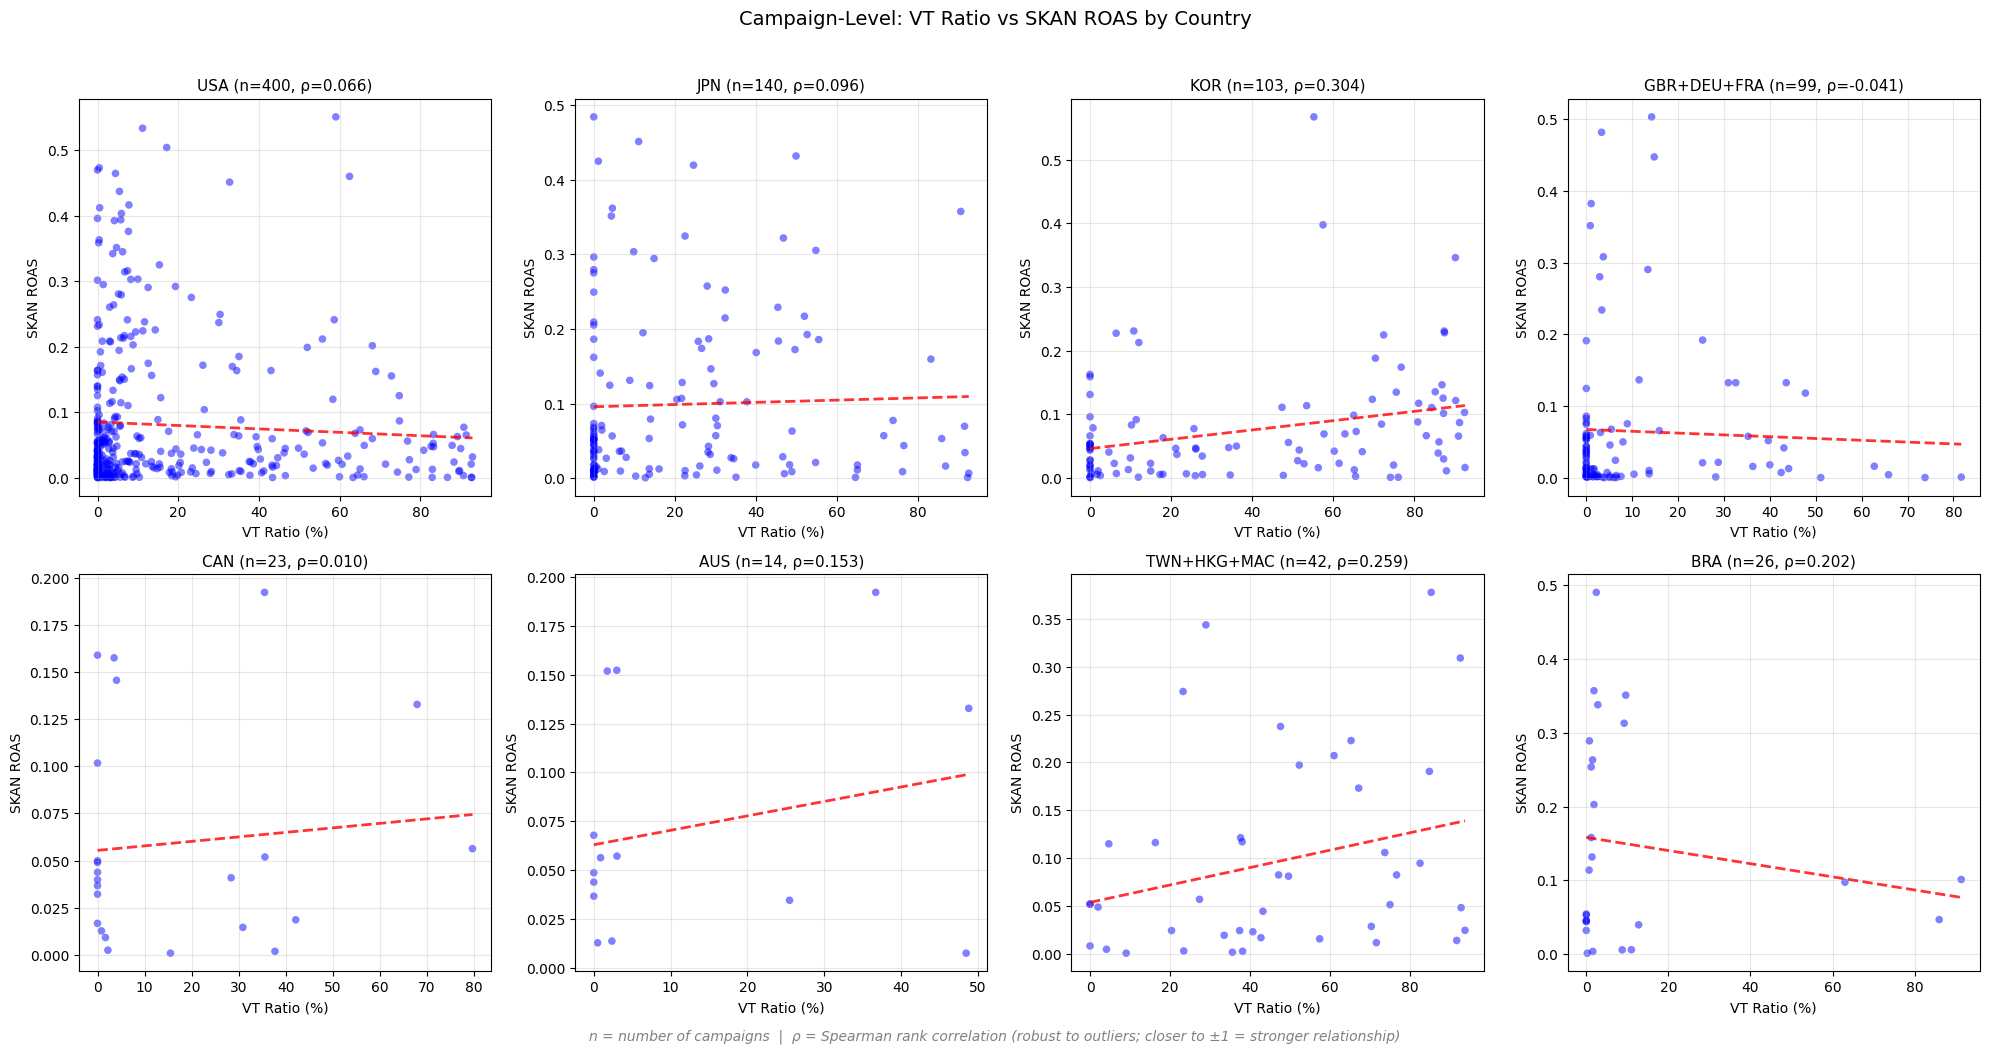

Chart saved as campaign_vt_skan_roas_by_country.png


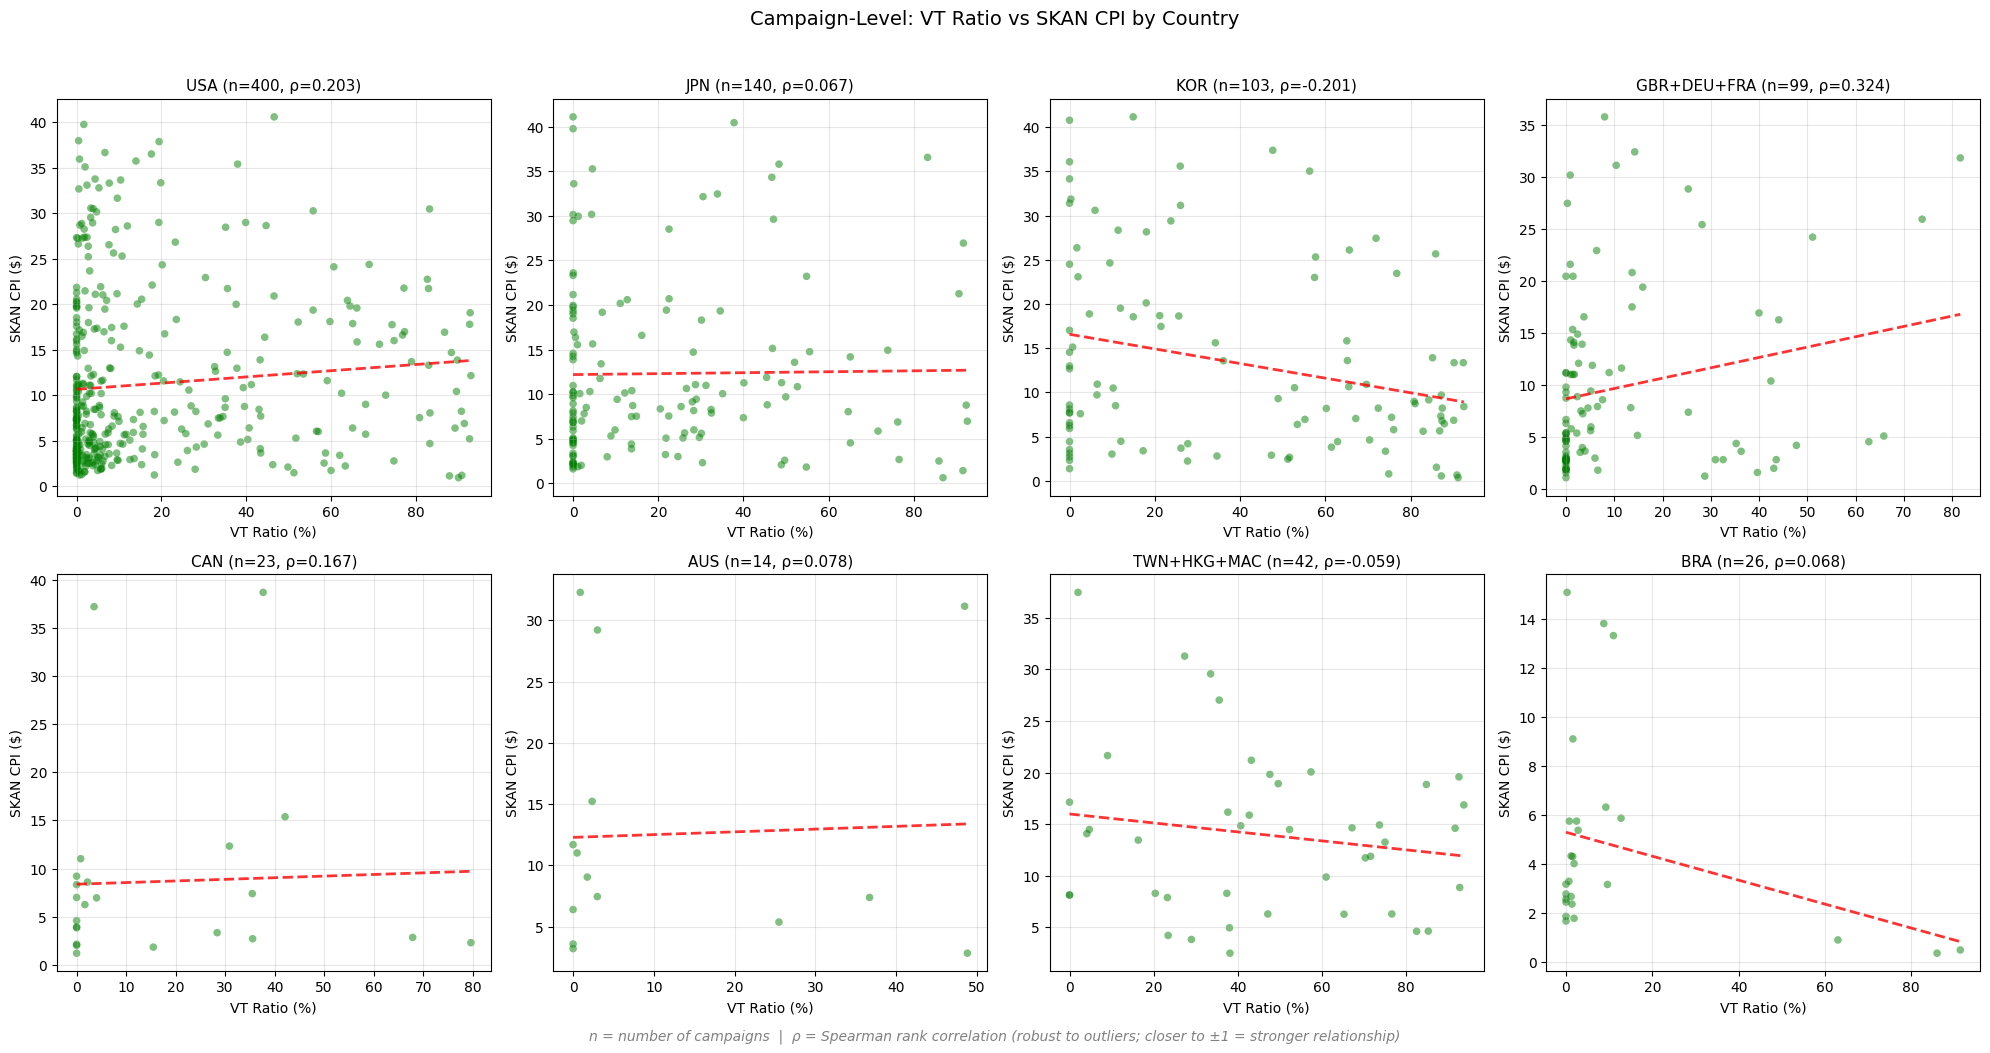

Chart saved as campaign_vt_skan_cpi_by_country.png


In [62]:
# Get countries with enough data for visualization
countries_for_plot = df_perf_corr[df_perf_corr['N'] >= 10]['Country'].tolist()
n_plots = len(countries_for_plot)
n_cols = min(n_plots, 4)
n_rows = (n_plots + n_cols - 1) // n_cols if n_plots > 0 else 1

if len(countries_for_plot) > 0:
    # ===== VT vs SKAN ROAS by Country =====
    fig1, axes1 = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
    axes1 = axes1.flatten()
    
    for idx, country in enumerate(countries_for_plot):
        country_data = df_perf_clean[df_perf_clean['country'] == country]
        
        if len(country_data) >= 10:
            ax = axes1[idx]
            ax.scatter(country_data['vt_ratio_pct'], country_data['skan_roas'], 
                      alpha=0.5, s=30, c='blue', edgecolors='none')
            
            # Add trend line
            z = np.polyfit(country_data['vt_ratio_pct'], country_data['skan_roas'], 1)
            p = np.poly1d(z)
            x_sorted = country_data['vt_ratio_pct'].sort_values()
            ax.plot(x_sorted, p(x_sorted), 'r--', alpha=0.8, linewidth=2)
            
            corr_row = df_perf_corr[df_perf_corr['Country'] == country]
            sp_val = corr_row['Spearman_ROAS'].values[0] if len(corr_row) > 0 else 0
            n_campaigns = len(country_data)
            ax.set_title(f'{country} (n={n_campaigns}, ρ={sp_val:.3f})', fontsize=11)
            ax.set_xlabel('VT Ratio (%)')
            ax.set_ylabel('SKAN ROAS')
            ax.grid(True, alpha=0.3)
        else:
            axes1[idx].set_visible(False)
    
    for idx in range(len(countries_for_plot), n_rows * n_cols):
        axes1[idx].set_visible(False)
    
    plt.suptitle('Campaign-Level: VT Ratio vs SKAN ROAS by Country', fontsize=14, y=1.02)
    fig1.text(0.5, -0.01, 'n = number of campaigns  |  ρ = Spearman rank correlation (robust to outliers; closer to ±1 = stronger relationship)',
              ha='center', fontsize=10, style='italic', color='gray')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'campaign_vt_skan_roas_by_country.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('Chart saved as campaign_vt_skan_roas_by_country.png')
    
    # ===== VT vs SKAN CPI by Country =====
    fig2, axes2 = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
    axes2 = axes2.flatten()
    
    for idx, country in enumerate(countries_for_plot):
        country_data = df_perf_clean[df_perf_clean['country'] == country]
        
        if len(country_data) >= 10:
            ax = axes2[idx]
            ax.scatter(country_data['vt_ratio_pct'], country_data['skan_cpi'], 
                      alpha=0.5, s=30, c='green', edgecolors='none')
            
            z = np.polyfit(country_data['vt_ratio_pct'], country_data['skan_cpi'], 1)
            p = np.poly1d(z)
            x_sorted = country_data['vt_ratio_pct'].sort_values()
            ax.plot(x_sorted, p(x_sorted), 'r--', alpha=0.8, linewidth=2)
            
            corr_row = df_perf_corr[df_perf_corr['Country'] == country]
            sp_val = corr_row['Spearman_CPI'].values[0] if len(corr_row) > 0 else 0
            n_campaigns = len(country_data)
            ax.set_title(f'{country} (n={n_campaigns}, ρ={sp_val:.3f})', fontsize=11)
            ax.set_xlabel('VT Ratio (%)')
            ax.set_ylabel('SKAN CPI ($)')
            ax.grid(True, alpha=0.3)
        else:
            axes2[idx].set_visible(False)
    
    for idx in range(len(countries_for_plot), n_rows * n_cols):
        axes2[idx].set_visible(False)
    
    plt.suptitle('Campaign-Level: VT Ratio vs SKAN CPI by Country', fontsize=14, y=1.02)
    fig2.text(0.5, -0.01, 'n = number of campaigns  |  ρ = Spearman rank correlation (robust to outliers; closer to ±1 = stronger relationship)',
              ha='center', fontsize=10, style='italic', color='gray')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'campaign_vt_skan_cpi_by_country.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('Chart saved as campaign_vt_skan_cpi_by_country.png')
else:
    print('Not enough data for visualization')

---
### Step 7: Visualization - VT vs Discrepancy by Geo (Campaign-Level)

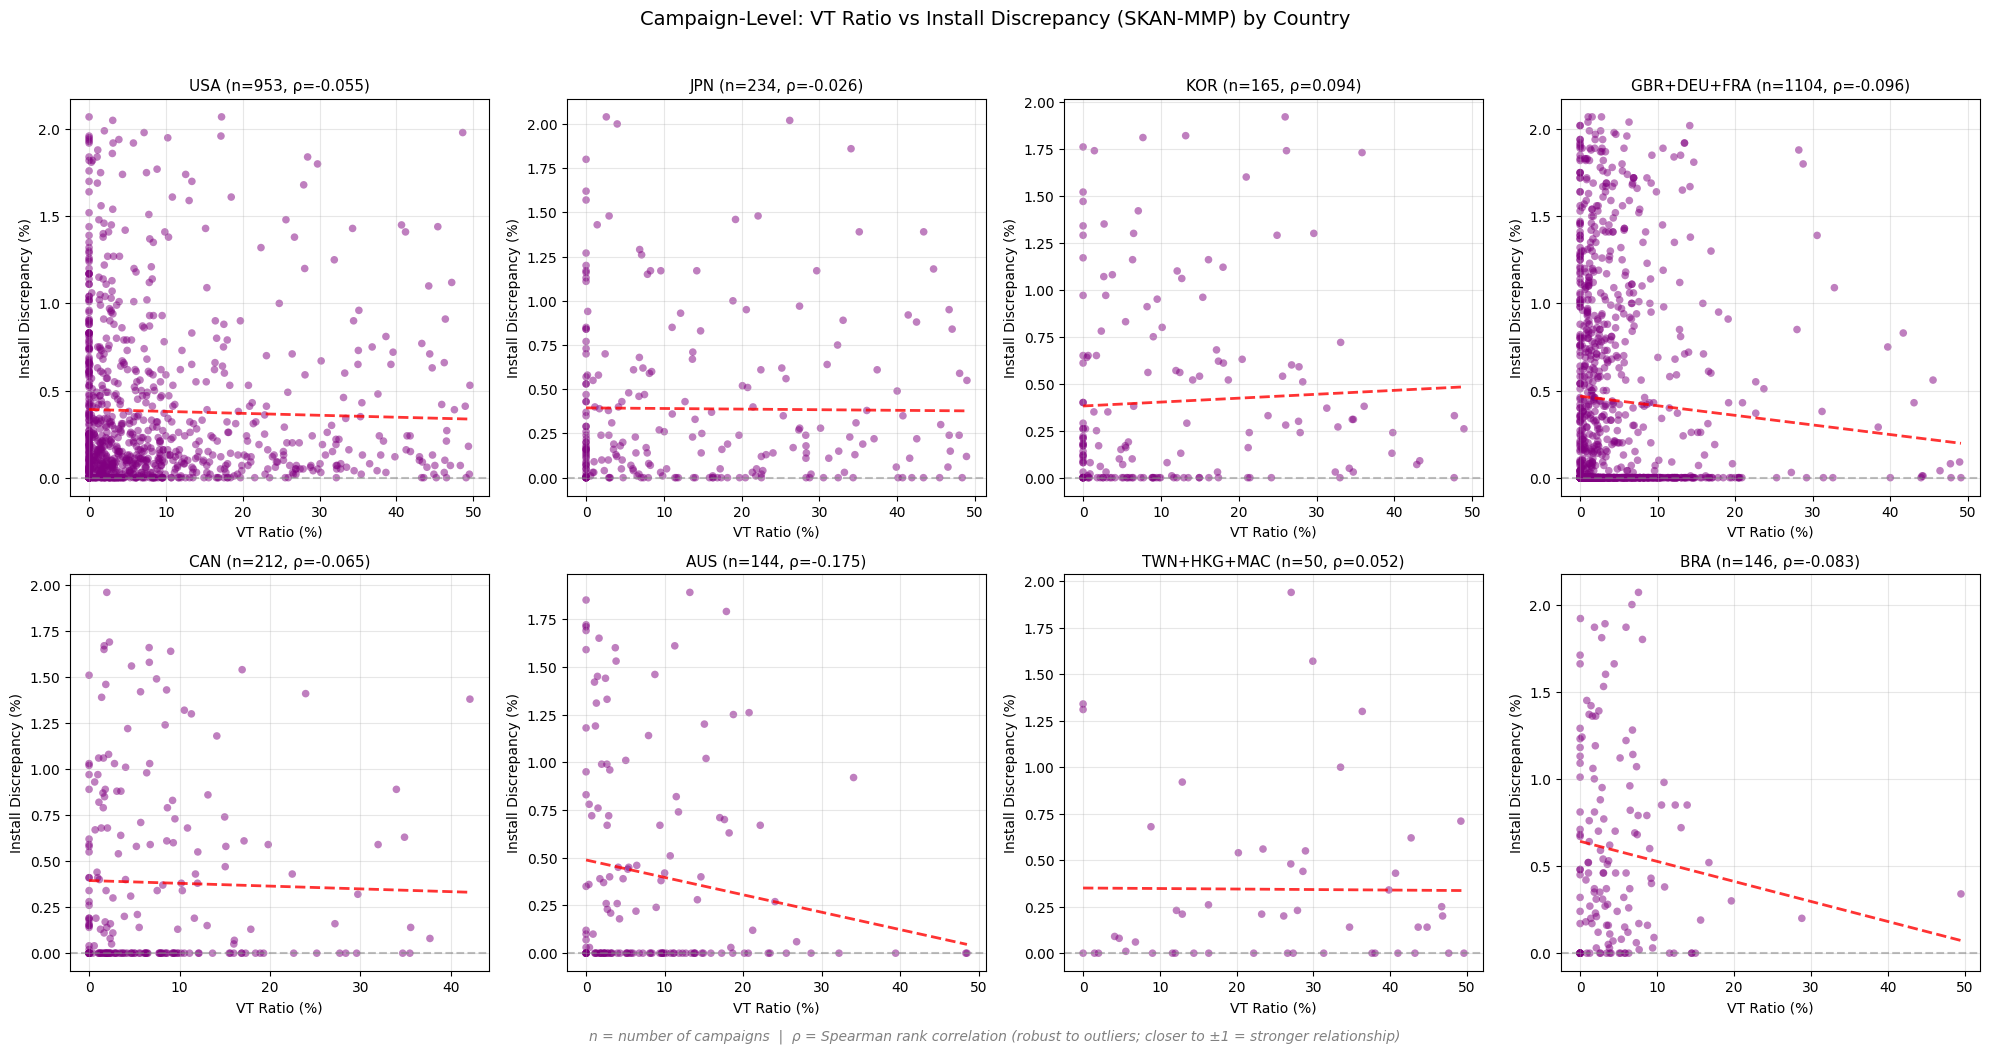

Chart saved as campaign_vt_install_disc_by_country.png


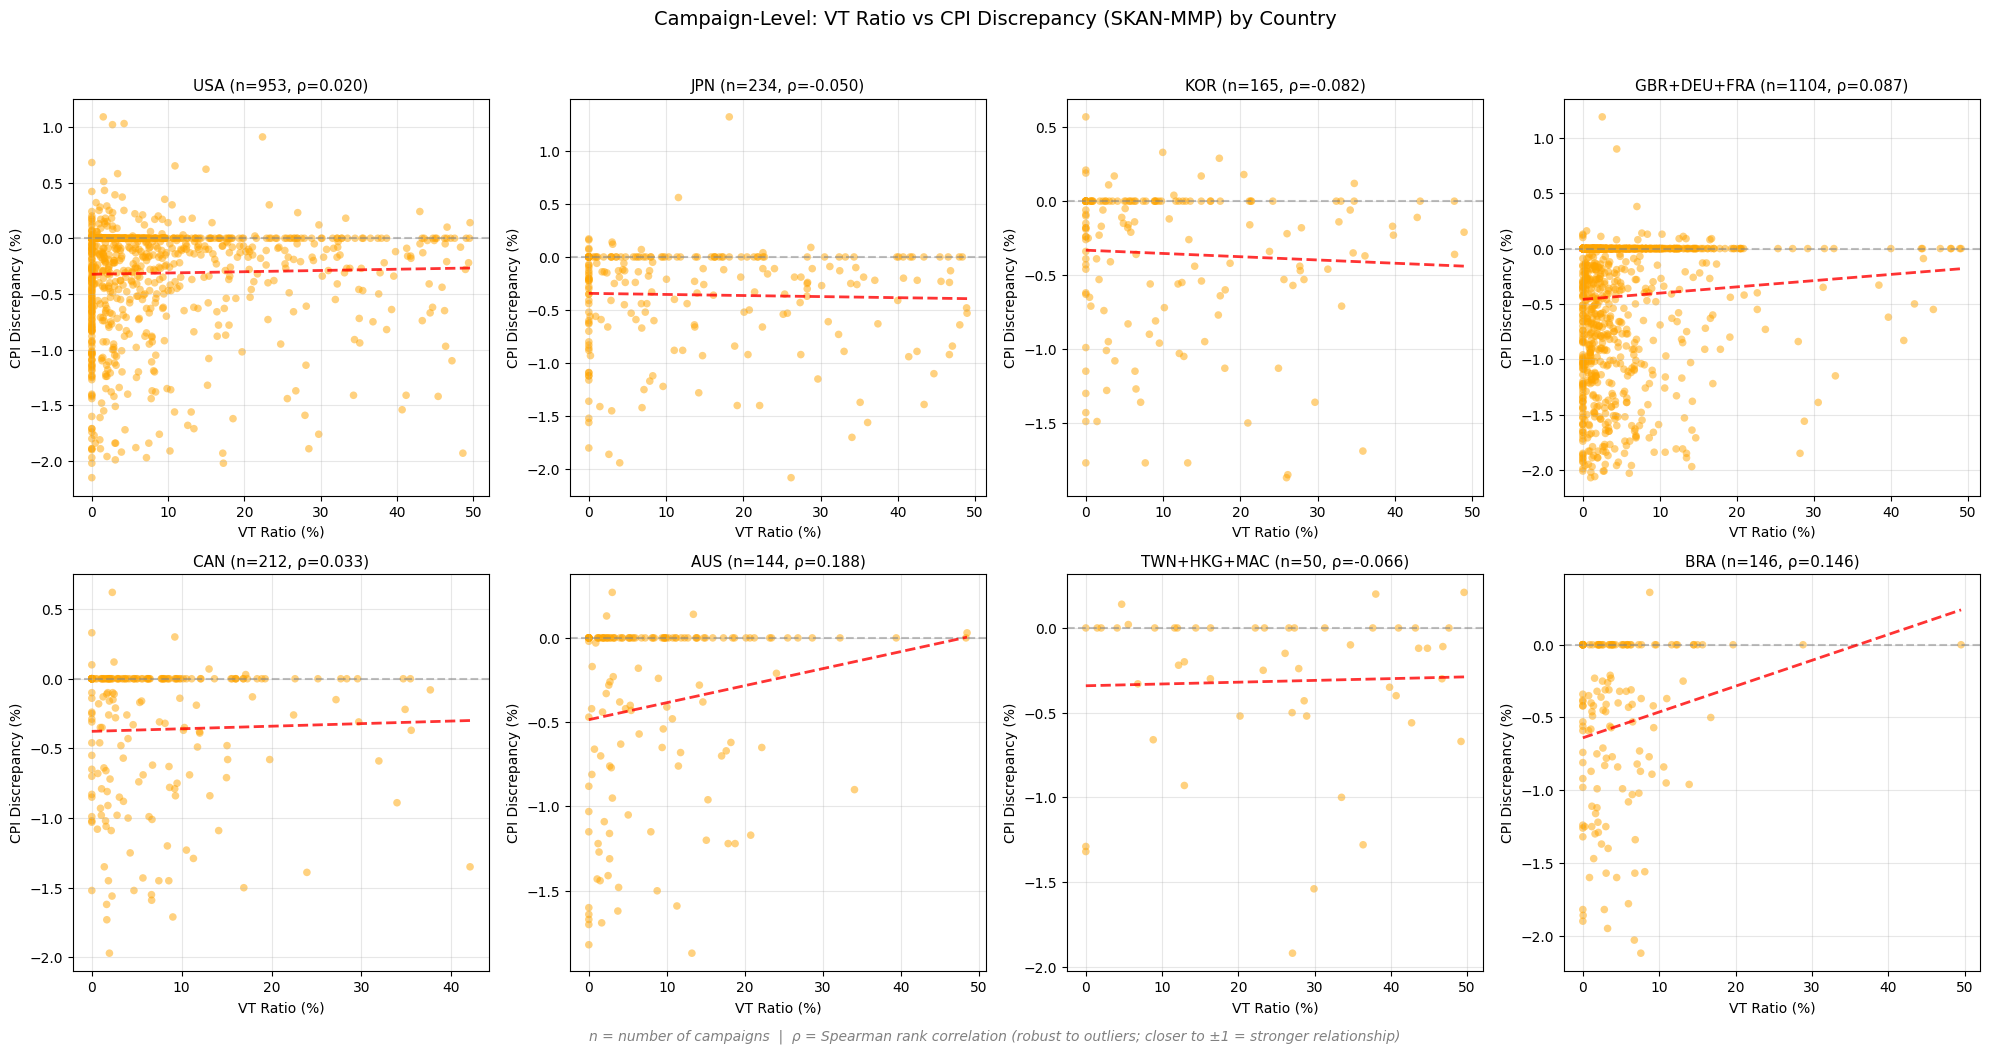

Chart saved as campaign_vt_cpi_disc_by_country.png


In [63]:
# Get countries with enough data
countries_disc_plot = df_disc_corr[df_disc_corr['N'] >= 10]['Country'].tolist()
n_disc = len(countries_disc_plot)
n_disc_cols = min(n_disc, 4)
n_disc_rows = (n_disc + n_disc_cols - 1) // n_disc_cols if n_disc > 0 else 1

if len(countries_disc_plot) > 0:
    # ===== VT vs Install Discrepancy by Country =====
    fig3, axes3 = plt.subplots(n_disc_rows, n_disc_cols, figsize=(5 * n_disc_cols, 5 * n_disc_rows))
    axes3 = axes3.flatten()
    
    for idx, country in enumerate(countries_disc_plot):
        country_data = df_disc_clean[df_disc_clean['country'] == country]
        
        if len(country_data) >= 10:
            ax = axes3[idx]
            ax.scatter(country_data['vt_ratio_pct'], country_data['install_disc_pct'], 
                      alpha=0.5, s=30, c='purple', edgecolors='none')
            ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
            
            z = np.polyfit(country_data['vt_ratio_pct'], country_data['install_disc_pct'], 1)
            p = np.poly1d(z)
            x_sorted = country_data['vt_ratio_pct'].sort_values()
            ax.plot(x_sorted, p(x_sorted), 'r--', alpha=0.8, linewidth=2)
            
            corr_row = df_disc_corr[df_disc_corr['Country'] == country]
            sp_val = corr_row['Spearman_Inst'].values[0] if len(corr_row) > 0 and pd.notna(corr_row['Spearman_Inst'].values[0]) else 0
            n_campaigns = len(country_data)
            ax.set_title(f'{country} (n={n_campaigns}, ρ={sp_val:.3f})', fontsize=11)
            ax.set_xlabel('VT Ratio (%)')
            ax.set_ylabel('Install Discrepancy (%)')
            ax.grid(True, alpha=0.3)
        else:
            axes3[idx].set_visible(False)
    
    for idx in range(len(countries_disc_plot), n_disc_rows * n_disc_cols):
        axes3[idx].set_visible(False)
    
    plt.suptitle('Campaign-Level: VT Ratio vs Install Discrepancy (SKAN-MMP) by Country', fontsize=14, y=1.02)
    fig3.text(0.5, -0.01, 'n = number of campaigns  |  ρ = Spearman rank correlation (robust to outliers; closer to ±1 = stronger relationship)',
              ha='center', fontsize=10, style='italic', color='gray')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'campaign_vt_install_disc_by_country.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('Chart saved as campaign_vt_install_disc_by_country.png')
    
    # ===== VT vs CPI Discrepancy by Country =====
    fig4, axes4 = plt.subplots(n_disc_rows, n_disc_cols, figsize=(5 * n_disc_cols, 5 * n_disc_rows))
    axes4 = axes4.flatten()
    
    for idx, country in enumerate(countries_disc_plot):
        country_data = df_disc_clean[df_disc_clean['country'] == country]
        
        if len(country_data) >= 10:
            ax = axes4[idx]
            ax.scatter(country_data['vt_ratio_pct'], country_data['cpi_disc_pct'], 
                      alpha=0.5, s=30, c='orange', edgecolors='none')
            ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
            
            z = np.polyfit(country_data['vt_ratio_pct'], country_data['cpi_disc_pct'], 1)
            p = np.poly1d(z)
            x_sorted = country_data['vt_ratio_pct'].sort_values()
            ax.plot(x_sorted, p(x_sorted), 'r--', alpha=0.8, linewidth=2)
            
            corr_row = df_disc_corr[df_disc_corr['Country'] == country]
            sp_val = corr_row['Spearman_CPI'].values[0] if len(corr_row) > 0 and pd.notna(corr_row['Spearman_CPI'].values[0]) else 0
            n_campaigns = len(country_data)
            ax.set_title(f'{country} (n={n_campaigns}, ρ={sp_val:.3f})', fontsize=11)
            ax.set_xlabel('VT Ratio (%)')
            ax.set_ylabel('CPI Discrepancy (%)')
            ax.grid(True, alpha=0.3)
        else:
            axes4[idx].set_visible(False)
    
    for idx in range(len(countries_disc_plot), n_disc_rows * n_disc_cols):
        axes4[idx].set_visible(False)
    
    plt.suptitle('Campaign-Level: VT Ratio vs CPI Discrepancy (SKAN-MMP) by Country', fontsize=14, y=1.02)
    fig4.text(0.5, -0.01, 'n = number of campaigns  |  ρ = Spearman rank correlation (robust to outliers; closer to ±1 = stronger relationship)',
              ha='center', fontsize=10, style='italic', color='gray')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'campaign_vt_cpi_disc_by_country.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('Chart saved as campaign_vt_cpi_disc_by_country.png')
else:
    print('Not enough data for visualization')

---
### Step 8: Overall Correlation Summary (All Geos Pooled)

In [64]:
print('='*100)
print('OVERALL CORRELATION SUMMARY (All Countries Pooled) — Pearson + Spearman')
print('='*100)
print(f'Total campaigns analyzed: {len(df_perf_clean)} (performance), {len(df_disc_clean)} (discrepancy)')

# Overall Performance Correlations
if len(df_perf_clean) > 10:
    pr_roas_all, pp_roas_all = stats.pearsonr(df_perf_clean['vt_ratio_pct'], df_perf_clean['skan_roas'])
    sr_roas_all, sp_roas_all = stats.spearmanr(df_perf_clean['vt_ratio_pct'], df_perf_clean['skan_roas'])
    pr_cpi_all, pp_cpi_all = stats.pearsonr(df_perf_clean['vt_ratio_pct'], df_perf_clean['skan_cpi'])
    sr_cpi_all, sp_cpi_all = stats.spearmanr(df_perf_clean['vt_ratio_pct'], df_perf_clean['skan_cpi'])
    
    print('\n[VT vs SKAN Performance - All Campaigns]')
    print(f'  VT vs SKAN ROAS:  Pearson r={pr_roas_all:.4f} (p={pp_roas_all:.4f})  Spearman ρ={sr_roas_all:.4f} (p={sp_roas_all:.4f})')
    print(f'  VT vs SKAN CPI:   Pearson r={pr_cpi_all:.4f} (p={pp_cpi_all:.4f})  Spearman ρ={sr_cpi_all:.4f} (p={sp_cpi_all:.4f})')

# Overall Discrepancy Correlations
if len(df_disc_clean) > 10:
    pr_inst_all, pp_inst_all = stats.pearsonr(df_disc_clean['vt_ratio_pct'], df_disc_clean['install_disc_pct'])
    sr_inst_all, sp_inst_all = stats.spearmanr(df_disc_clean['vt_ratio_pct'], df_disc_clean['install_disc_pct'])
    pr_cpi_disc_all, pp_cpi_disc_all = stats.pearsonr(df_disc_clean['vt_ratio_pct'], df_disc_clean['cpi_disc_pct'])
    sr_cpi_disc_all, sp_cpi_disc_all = stats.spearmanr(df_disc_clean['vt_ratio_pct'], df_disc_clean['cpi_disc_pct'])
    
    print('\n[VT vs MMP-SKAN Discrepancy - All Campaigns]')
    print(f'  VT vs Install Disc:  Pearson r={pr_inst_all:.4f} (p={pp_inst_all:.4f})  Spearman ρ={sr_inst_all:.4f} (p={sp_inst_all:.4f})')
    print(f'  VT vs CPI Disc:      Pearson r={pr_cpi_disc_all:.4f} (p={pp_cpi_disc_all:.4f})  Spearman ρ={sr_cpi_disc_all:.4f} (p={sp_cpi_disc_all:.4f})')

print('\n' + '-'*100)

# Combined results table
print('\n' + '='*100)
print('COMBINED CORRELATION RESULTS BY GEO (Spearman)')
print('='*100)

df_combined = df_perf_corr[['Country', 'N', 'Avg_VT', 'Med_VT',
                             'Pearson_ROAS', 'Spearman_ROAS', 'Sig_ROAS',
                             'Pearson_CPI', 'Spearman_CPI', 'Sig_CPI']].copy()
df_disc_subset = df_disc_corr[['Country',
                                'Pearson_Inst', 'Spearman_Inst', 'Sig_Inst',
                                'Pearson_CPI', 'Spearman_CPI', 'Sig_CPI']].copy()
df_disc_subset.columns = ['Country',
                           'Pearson_InstDisc', 'Spearman_InstDisc', 'Sig_InstDisc',
                           'Pearson_CPIDisc', 'Spearman_CPIDisc', 'Sig_CPIDisc']
df_combined = df_combined.merge(df_disc_subset, on='Country', how='left')

print(df_combined.to_string(index=False))

OVERALL CORRELATION SUMMARY (All Countries Pooled) — Pearson + Spearman
Total campaigns analyzed: 847 (performance), 3008 (discrepancy)

[VT vs SKAN Performance - All Campaigns]
  VT vs SKAN ROAS:  Pearson r=0.0229 (p=0.5058)  Spearman ρ=0.1017 (p=0.0030)
  VT vs SKAN CPI:   Pearson r=0.0492 (p=0.1529)  Spearman ρ=0.1620 (p=0.0000)

[VT vs MMP-SKAN Discrepancy - All Campaigns]
  VT vs Install Disc:  Pearson r=-0.0527 (p=0.0039)  Spearman ρ=-0.0530 (p=0.0037)
  VT vs CPI Disc:      Pearson r=0.0580 (p=0.0015)  Spearman ρ=0.0491 (p=0.0070)

----------------------------------------------------------------------------------------------------

COMBINED CORRELATION RESULTS BY GEO (Spearman)
    Country   N  Avg_VT  Med_VT  Pearson_ROAS  Spearman_ROAS Sig_ROAS  Pearson_CPI  Spearman_CPI Sig_CPI  Pearson_InstDisc  Spearman_InstDisc Sig_InstDisc  Pearson_CPIDisc  Spearman_CPIDisc Sig_CPIDisc
        USA 400    17.5     4.4        -0.061          0.066                 0.095         0.203       *

---
### Step 9: VT Bucket Analysis (Campaign-Level)

In [65]:
# Create VT ratio buckets
df_perf_clean['vt_bucket'] = pd.cut(
    df_perf_clean['vt_ratio_pct'], 
    bins=[0, 20, 40, 60, 80, 100],
    labels=['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']
)

print('='*100)
print('SKAN PERFORMANCE BY VT RATIO BUCKET (Campaign-Level)')
print('='*100)

# Overall bucket summary — mean and median side by side
bucket_mean = df_perf_clean.groupby('vt_bucket').agg({
    'campaign_id': 'count',
    'bundle': 'nunique',
    'vt_ratio_pct': 'mean',
    'skan_roas': 'mean',
    'skan_cpi': 'mean',
    'mmp_spend': 'sum'
}).round(4)
bucket_mean.columns = ['N', 'N_Bundles', 'Avg_VT_Ratio', 'Avg_SKAN_ROAS', 'Avg_SKAN_CPI', 'Total_Spend']

bucket_median = df_perf_clean.groupby('vt_bucket').agg({
    'skan_roas': 'median',
    'skan_cpi': 'median'
}).round(4)
bucket_median.columns = ['Med_SKAN_ROAS', 'Med_SKAN_CPI']

bucket_summary = bucket_mean.join(bucket_median)
bucket_summary = bucket_summary[['N', 'N_Bundles', 'Avg_VT_Ratio',
                                  'Avg_SKAN_ROAS', 'Med_SKAN_ROAS',
                                  'Avg_SKAN_CPI', 'Med_SKAN_CPI', 'Total_Spend']]
bucket_summary['Total_Spend'] = bucket_summary['Total_Spend'].apply(lambda x: f'${x:,.0f}')

print('\n[OVERALL - All Countries]  (Med = Median)')
print(bucket_summary)

# By country bucket summary
print('\n' + '-'*100)
print('\n[BY COUNTRY - SKAN ROAS by VT Bucket]')

for country in ANALYSIS_COUNTRIES:
    c_data = df_perf_clean[df_perf_clean['country'] == country]
    if len(c_data) >= 20:
        c_mean = c_data.groupby('vt_bucket').agg({
            'campaign_id': 'count',
            'skan_roas': 'mean',
            'skan_cpi': 'mean'
        }).round(4)
        c_mean.columns = ['N', 'Avg_ROAS', 'Avg_CPI']
        c_med = c_data.groupby('vt_bucket').agg({
            'skan_roas': 'median',
            'skan_cpi': 'median'
        }).round(4)
        c_med.columns = ['Med_ROAS', 'Med_CPI']
        c_bucket = c_mean.join(c_med)[['N', 'Avg_ROAS', 'Med_ROAS', 'Avg_CPI', 'Med_CPI']]
        print(f'\n  {country}:')
        print(c_bucket.to_string().replace('\n', '\n    '))

SKAN PERFORMANCE BY VT RATIO BUCKET (Campaign-Level)

[OVERALL - All Countries]  (Med = Median)
             N  N_Bundles  Avg_VT_Ratio  Avg_SKAN_ROAS  Med_SKAN_ROAS  \
vt_bucket                                                               
0-20%      321        180        5.8973         0.1017         0.0439   
20-40%     109         77       29.9110         0.0805         0.0431   
40-60%      72         50       49.3983         0.1010         0.0446   
60-80%      60         42       69.3895         0.0727         0.0504   
80-100%     59         35       87.8858         0.0814         0.0525   

           Avg_SKAN_CPI  Med_SKAN_CPI  Total_Spend  
vt_bucket                                           
0-20%           12.8898         9.250  $27,391,282  
20-40%          12.5177         8.610   $6,707,182  
40-60%          13.3281        11.280   $4,522,014  
60-80%          11.3225        10.105   $4,646,753  
80-100%         10.6876         8.410   $5,251,470  

--------------------

---
### Step 9b: Visualize VT Bucket Analysis by Country

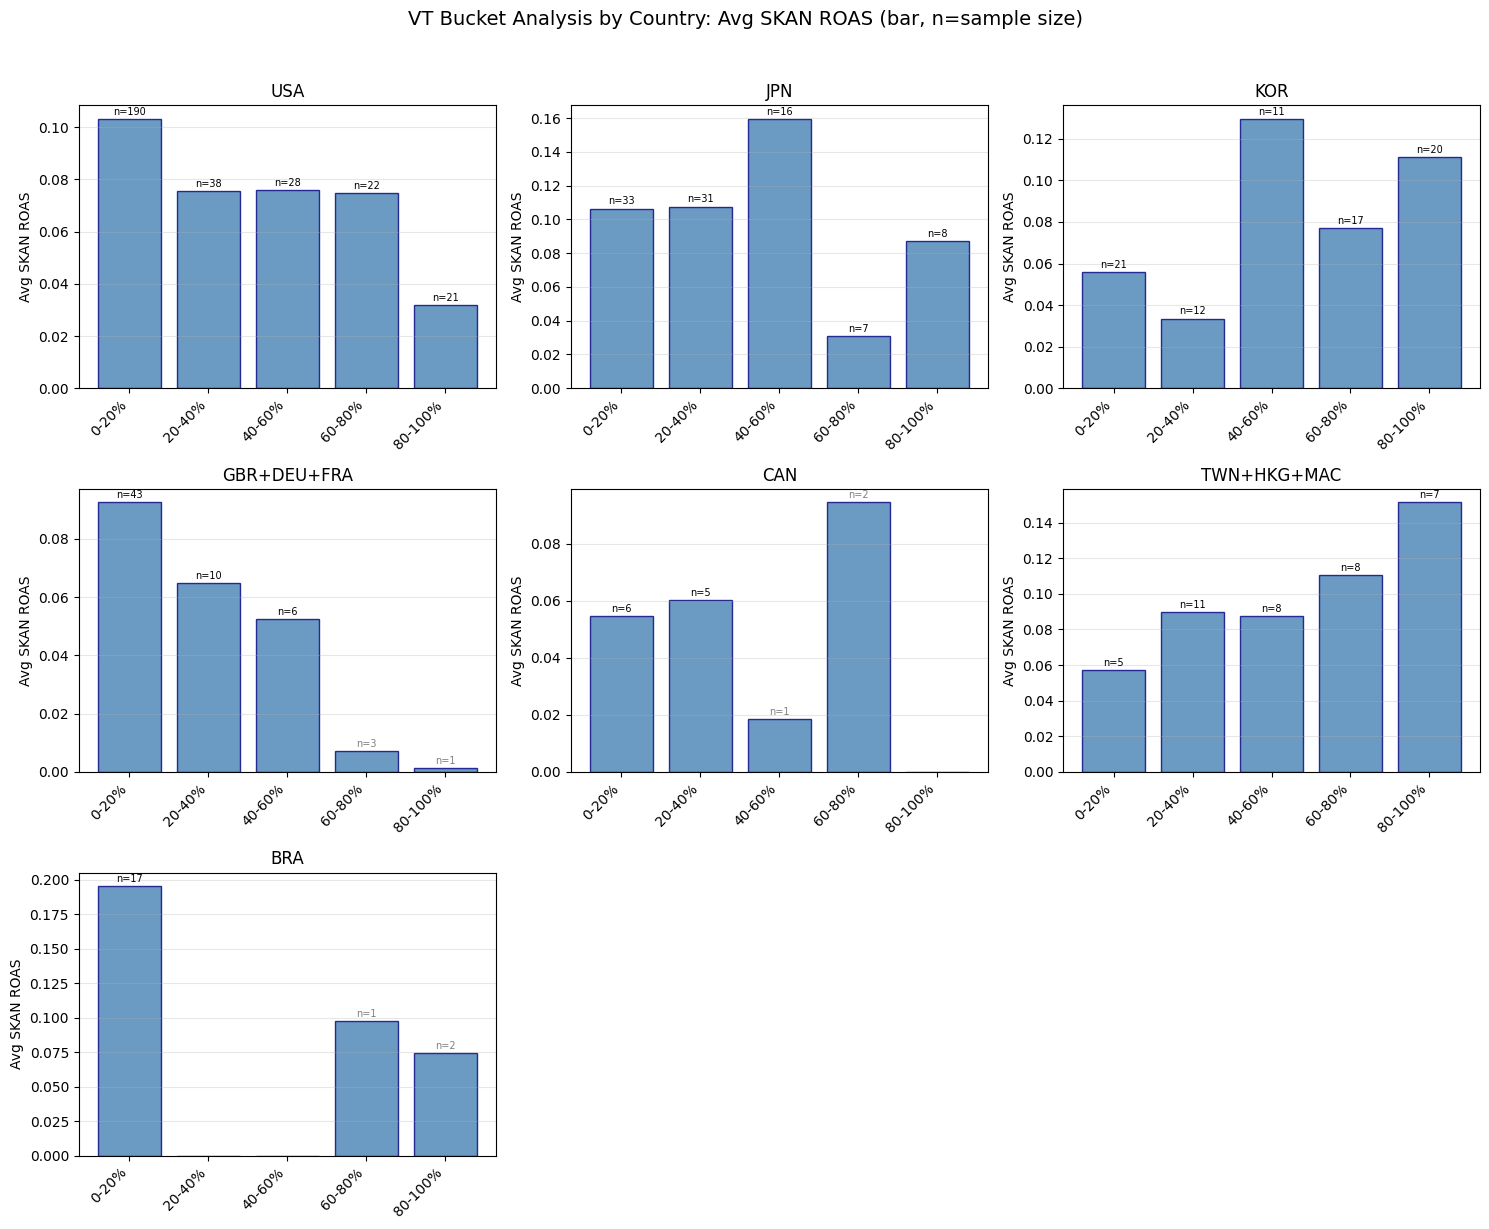

Saved: vt_bucket_skan_roas_by_country.png


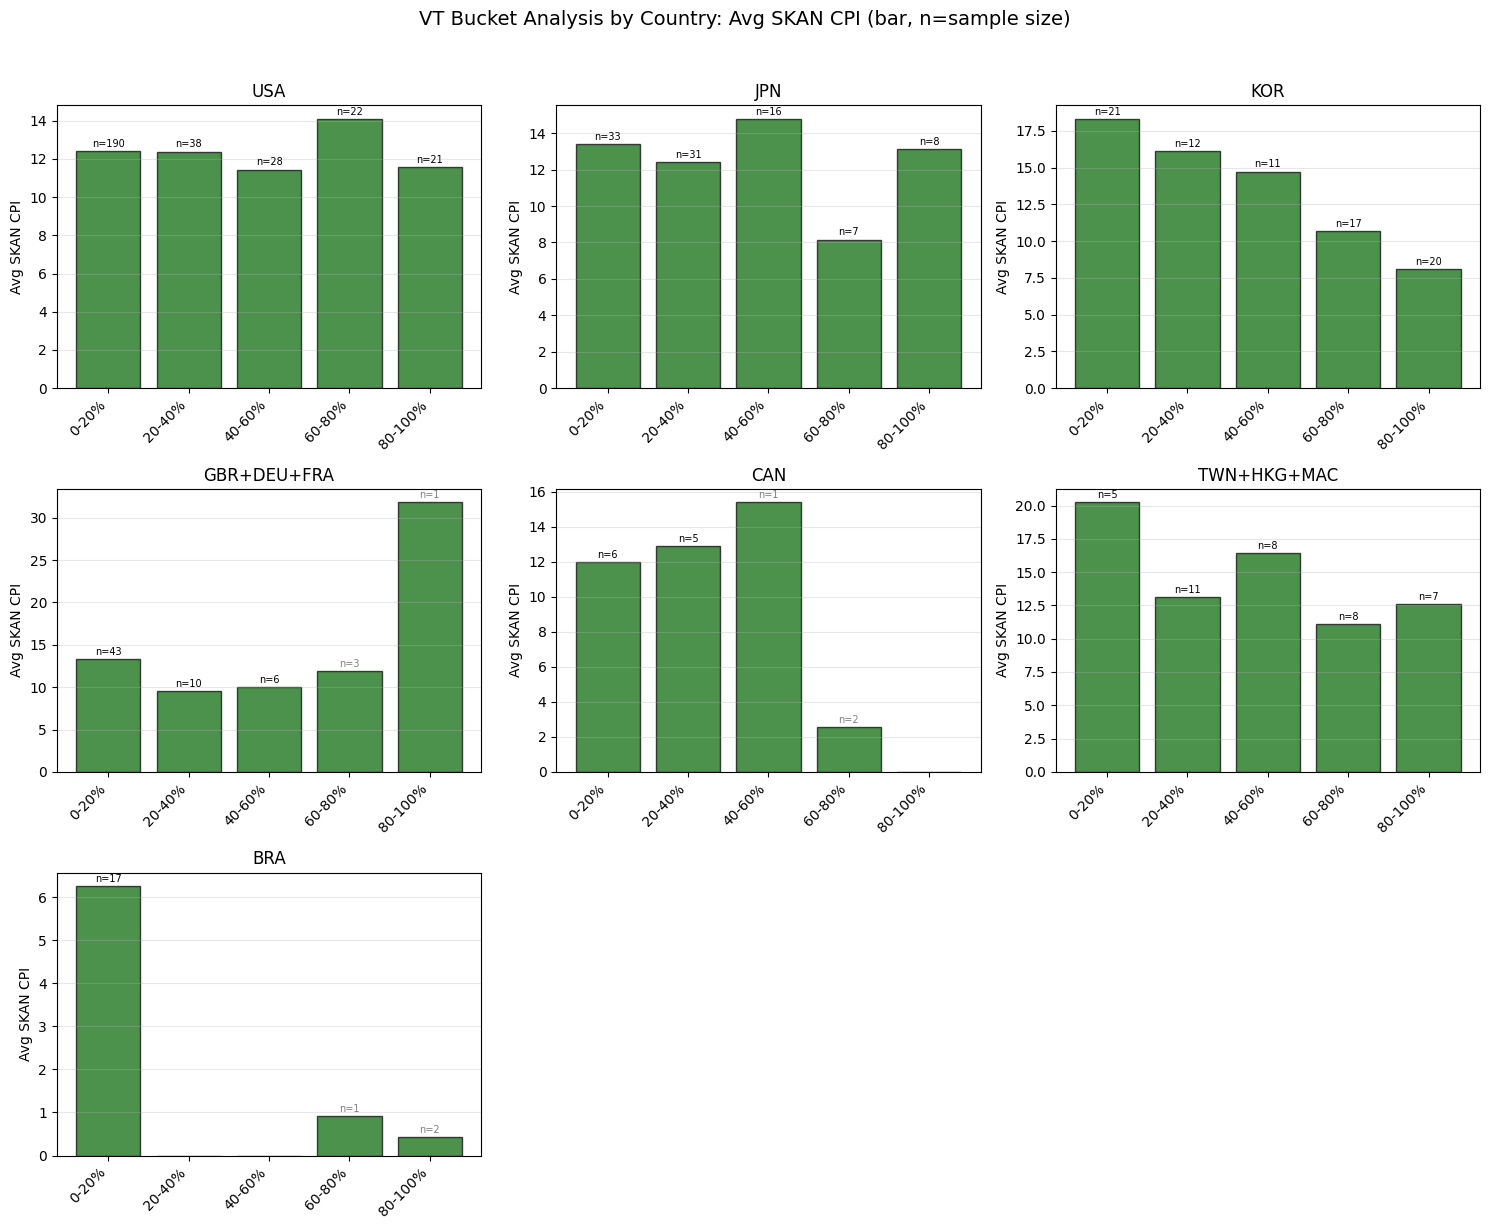

Saved: vt_bucket_skan_cpi_by_country.png


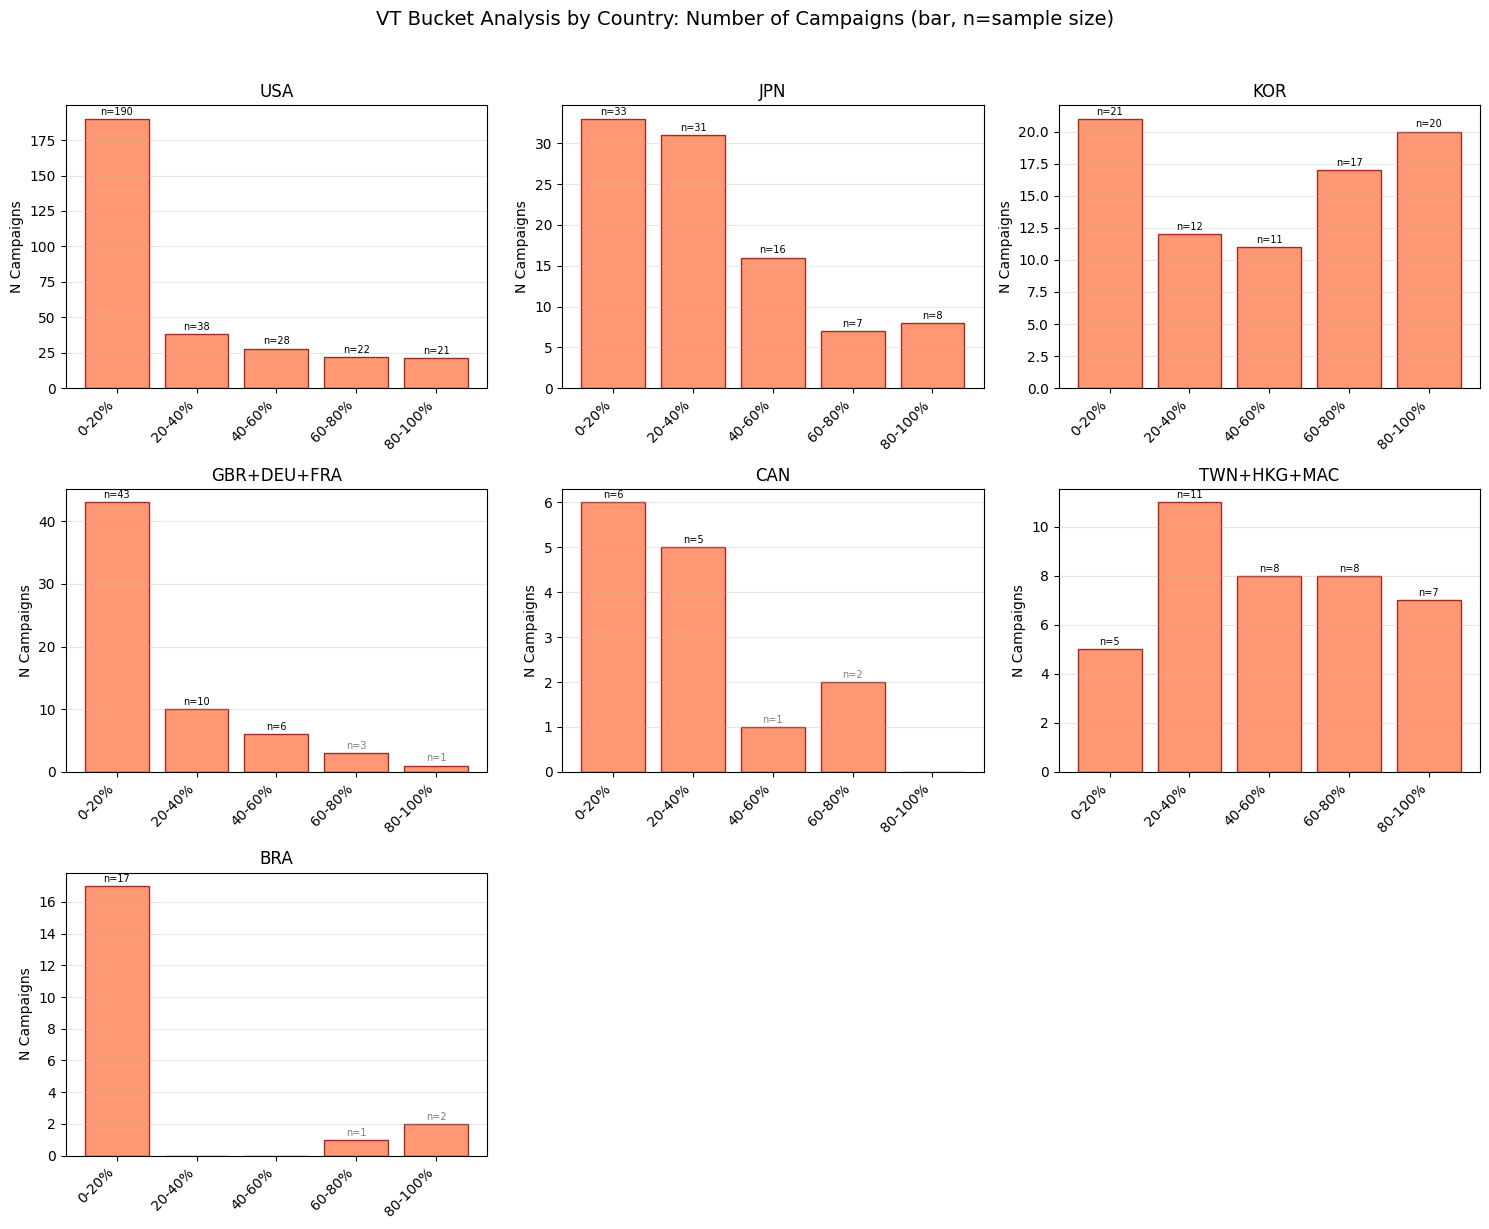

Saved: vt_bucket_n_campaigns_by_country.png

QUICK INTERPRETATIONS (VT Bucket by Country)

  USA: N=299 campaigns across buckets. All buckets have n>=5. ROAS trend across VT buckets: r=-0.900, p=0.037 (significant).

  JPN: N=95 campaigns across buckets. All buckets have n>=5. ROAS trend across VT buckets: r=-0.500, p=0.391 (not significant).

  KOR: N=81 campaigns across buckets. All buckets have n>=5. ROAS trend across VT buckets: r=0.600, p=0.285 (not significant).

  GBR+DEU+FRA: N=63 campaigns across buckets. 2 bucket(s) have n<5 (interpret with caution). ROAS trend across VT buckets: r=-1.000, p=0.000 (significant).

  CAN: N=14 campaigns across buckets. 3 bucket(s) have n<5 (interpret with caution). ROAS trend across VT buckets: r=0.400, p=0.600 (not significant).

  TWN+HKG+MAC: N=39 campaigns across buckets. All buckets have n>=5. ROAS trend across VT buckets: r=0.900, p=0.037 (significant).

  BRA: N=20 campaigns across buckets. 4 bucket(s) have n<5 (interpret with caution). 

In [66]:
# Build country x VT bucket summary for plotting
bucket_by_country = df_perf_clean.groupby(['country', 'vt_bucket']).agg({
    'campaign_id': 'count',
    'skan_roas': 'mean',
    'skan_cpi': 'mean'
}).reset_index()
bucket_by_country.columns = ['country', 'vt_bucket', 'n_campaigns', 'skan_roas', 'skan_cpi']

# Countries with enough campaigns for at least 3 VT buckets
min_campaigns_per_country = 15
countries_with_data = [c for c in ANALYSIS_COUNTRIES 
                       if len(df_perf_clean[df_perf_clean['country'] == c]) >= min_campaigns_per_country]
bucket_order = ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']

# --- Figure 1: SKAN ROAS by VT bucket by country (bar chart with n) ---
n_countries = len(countries_with_data)
min_n_per_bucket_warn = 5  # flag buckets with n < this for caution
if n_countries > 0:
    n_cols = 3
    n_rows = (n_countries + n_cols - 1) // n_cols
    fig1, axes1 = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes1 = np.atleast_2d(axes1)
    for idx, country in enumerate(countries_with_data):
        row, col = idx // n_cols, idx % n_cols
        ax = axes1[row, col]
        data = bucket_by_country[bucket_by_country['country'] == country].set_index('vt_bucket').reindex(bucket_order)
        x = np.arange(len(bucket_order))
        roas_vals = data['skan_roas'].values
        roas_vals = np.where(np.isfinite(roas_vals), roas_vals, 0)
        n_vals = data['n_campaigns'].fillna(0).values.astype(int)
        bars = ax.bar(x, roas_vals, color='steelblue', edgecolor='navy', alpha=0.8)
        for i, (xv, n) in enumerate(zip(x, n_vals)):
            if n > 0: ax.annotate(f'n={int(n)}', (xv, roas_vals[i]), textcoords='offset points', xytext=(0, 3), ha='center', fontsize=7, color='gray' if n < min_n_per_bucket_warn else 'black')
        ax.set_xticks(x)
        ax.set_xticklabels(bucket_order, rotation=45, ha='right')
        ax.set_ylabel('Avg SKAN ROAS')
        ax.set_title(f'{country}')
        ax.grid(True, alpha=0.3, axis='y')
    for idx in range(n_countries, n_rows * n_cols):
        row, col = idx // n_cols, idx % n_cols
        axes1[row, col].set_visible(False)
    plt.suptitle('VT Bucket Analysis by Country: Avg SKAN ROAS (bar, n=sample size)', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'vt_bucket_skan_roas_by_country.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('Saved: vt_bucket_skan_roas_by_country.png')

    # --- Figure 2: SKAN CPI by VT bucket by country (bar chart with n) ---
    fig2, axes2 = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes2 = np.atleast_2d(axes2)
    for idx, country in enumerate(countries_with_data):
        row, col = idx // n_cols, idx % n_cols
        ax = axes2[row, col]
        data = bucket_by_country[bucket_by_country['country'] == country].set_index('vt_bucket').reindex(bucket_order)
        x = np.arange(len(bucket_order))
        cpi_vals = data['skan_cpi'].values
        cpi_vals = np.where(np.isfinite(cpi_vals), cpi_vals, 0)
        n_vals = data['n_campaigns'].fillna(0).values.astype(int)
        ax.bar(x, cpi_vals, color='darkgreen', edgecolor='black', alpha=0.7)
        for i, (xv, n) in enumerate(zip(x, n_vals)):
            if n > 0: ax.annotate(f'n={int(n)}', (xv, cpi_vals[i]), textcoords='offset points', xytext=(0, 3), ha='center', fontsize=7, color='gray' if n < min_n_per_bucket_warn else 'black')
        ax.set_xticks(x)
        ax.set_xticklabels(bucket_order, rotation=45, ha='right')
        ax.set_ylabel('Avg SKAN CPI')
        ax.set_title(f'{country}')
        ax.grid(True, alpha=0.3, axis='y')
    for idx in range(n_countries, n_rows * n_cols):
        row, col = idx // n_cols, idx % n_cols
        axes2[row, col].set_visible(False)
    plt.suptitle('VT Bucket Analysis by Country: Avg SKAN CPI (bar, n=sample size)', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'vt_bucket_skan_cpi_by_country.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('Saved: vt_bucket_skan_cpi_by_country.png')

    # --- Figure 3: Campaign count by VT bucket by country (bar chart with n on bars) ---
    fig3, axes3 = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes3 = np.atleast_2d(axes3)
    for idx, country in enumerate(countries_with_data):
        row, col = idx // n_cols, idx % n_cols
        ax = axes3[row, col]
        data = bucket_by_country[bucket_by_country['country'] == country].set_index('vt_bucket').reindex(bucket_order)
        x = np.arange(len(bucket_order))
        n_vals = data['n_campaigns'].fillna(0).values.astype(int)
        bars = ax.bar(x, n_vals, color='coral', edgecolor='darkred', alpha=0.8)
        for i, (xv, n) in enumerate(zip(x, n_vals)):
            if n > 0: ax.annotate(f'n={int(n)}', (xv, n_vals[i]), textcoords='offset points', xytext=(0, 3), ha='center', fontsize=7, color='gray' if n < min_n_per_bucket_warn else 'black')
        ax.set_xticks(x)
        ax.set_xticklabels(bucket_order, rotation=45, ha='right')
        ax.set_ylabel('N Campaigns')
        ax.set_title(f'{country}')
        ax.grid(True, alpha=0.3, axis='y')
    for idx in range(n_countries, n_rows * n_cols):
        row, col = idx // n_cols, idx % n_cols
        axes3[row, col].set_visible(False)
    plt.suptitle('VT Bucket Analysis by Country: Number of Campaigns (bar, n=sample size)', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'vt_bucket_n_campaigns_by_country.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('Saved: vt_bucket_n_campaigns_by_country.png')

    # --- Quick interpretations (sample size & statistical significance) ---
    print('\n' + '='*80)
    print('QUICK INTERPRETATIONS (VT Bucket by Country)')
    print('='*80)
    for country in countries_with_data:
        c_data = bucket_by_country[bucket_by_country['country'] == country]
        n_total = c_data['n_campaigns'].sum()
        n_buckets_with_low_n = (c_data['n_campaigns'] < min_n_per_bucket_warn).sum()
        roas_vals = c_data.set_index('vt_bucket').reindex(bucket_order)['skan_roas'].values
        roas_vals = roas_vals[np.isfinite(roas_vals)]
        if len(roas_vals) >= 3:
            r_trend, p_trend = stats.spearmanr(range(len(roas_vals)), roas_vals)
            sig = 'significant' if p_trend < 0.05 else 'not significant'
        else:
            r_trend, p_trend, sig = np.nan, np.nan, 'N/A (too few buckets)'
        print(f"\n  {country}: N={int(n_total)} campaigns across buckets. " +
              (f"{int(n_buckets_with_low_n)} bucket(s) have n<{min_n_per_bucket_warn} (interpret with caution). " if n_buckets_with_low_n > 0 else "All buckets have n>=%d. " % min_n_per_bucket_warn) +
              (f"ROAS trend across VT buckets: r={r_trend:.3f}, p={p_trend:.3f} ({sig})." if isinstance(sig, str) and 'N/A' not in sig else f"ROAS trend: {sig}"))
    print('\n  General caveats:')
    print('  - Points labeled with n<5 are low-sample; means can be unstable and not statistically reliable.')
    print('  - "Significant" trend (p<0.05) means the rank correlation (Spearman) of ROAS vs VT bucket is unlikely due to chance.')
    print('  - Line charts show pattern across buckets; avoid over-interpreting single buckets with small n.')
else:
    print('No country has enough campaigns (min 15) for VT bucket visualization.')

---
### Step 9c: VT Bucket Charts (Clean Version for External Sharing)

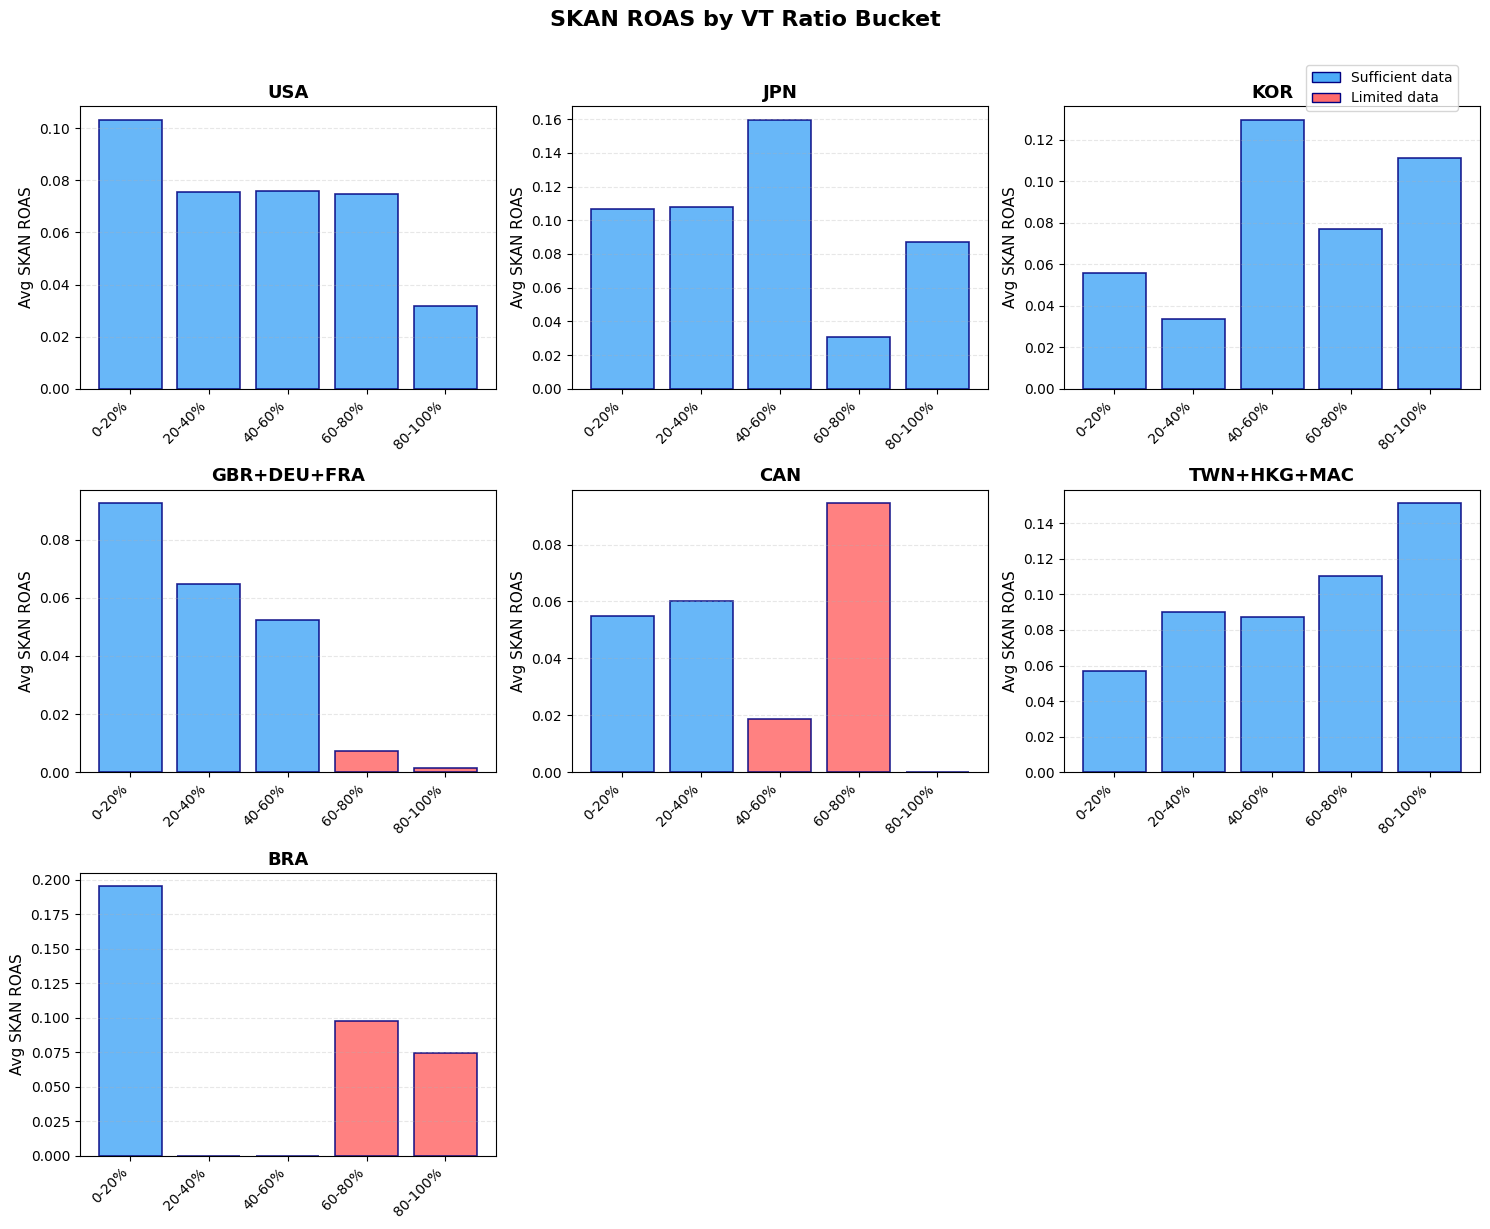

Saved: vt_bucket_skan_roas_clean.png


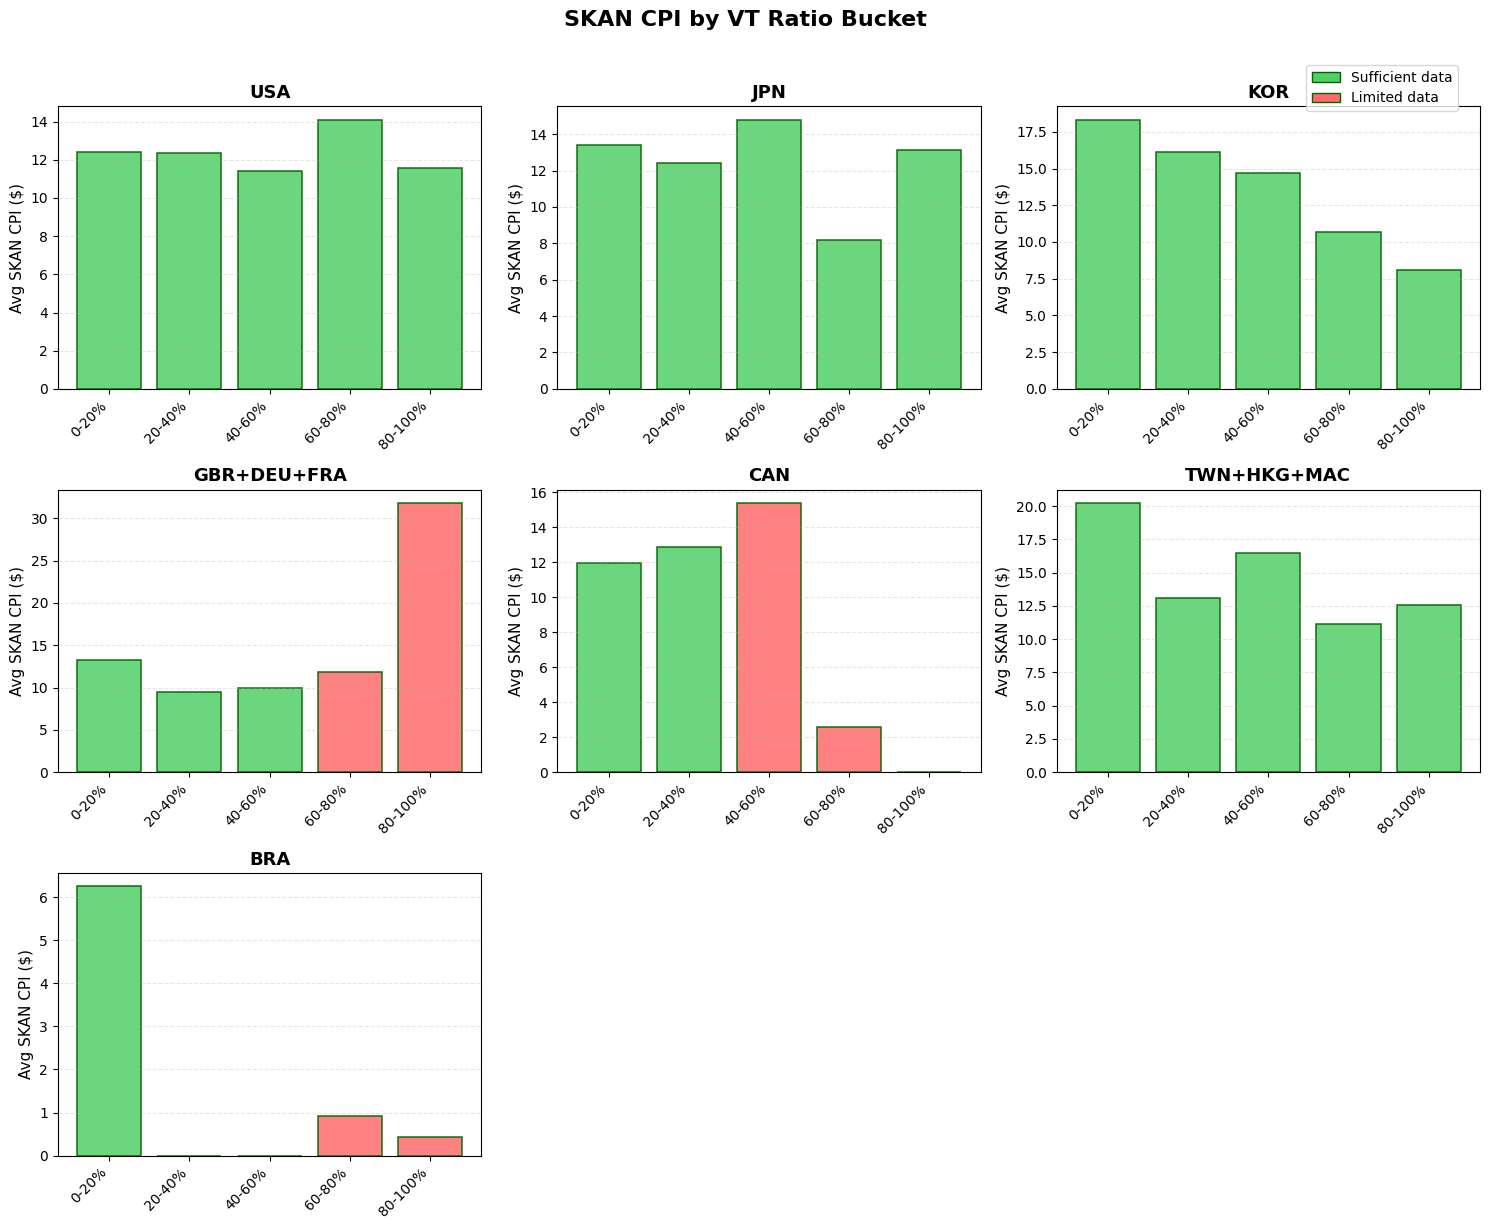

Saved: vt_bucket_skan_cpi_clean.png

Clean VT Bucket charts saved (color-coded by data reliability).
Blue/Green = Sufficient data, Red = Limited data


In [67]:
# Clean version without sample counts - suitable for external sharing
# Colors indicate sample size reliability (blue/green = n>=5, red = n<5)

import matplotlib.patches as mpatches

bucket_order = ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']
min_n_per_bucket_warn = 5

if 'bucket_by_country' not in dir():
    bucket_by_country = df_perf_clean.groupby(['country', 'vt_bucket']).agg({
        'campaign_id': 'count',
        'skan_roas': 'mean',
        'skan_cpi': 'mean'
    }).reset_index()
    bucket_by_country.columns = ['country', 'vt_bucket', 'n_campaigns', 'skan_roas', 'skan_cpi']

min_campaigns_per_country = 15
countries_with_data = [c for c in ANALYSIS_COUNTRIES 
                       if len(df_perf_clean[df_perf_clean['country'] == c]) >= min_campaigns_per_country]

n_countries = len(countries_with_data)
if n_countries > 0:
    n_cols = 3
    n_rows = (n_countries + n_cols - 1) // n_cols
    
    # --- Figure 1: SKAN ROAS by VT bucket (clean with color coding) ---
    fig1, axes1 = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes1 = np.atleast_2d(axes1)
    
    for idx, country in enumerate(countries_with_data):
        row, col = idx // n_cols, idx % n_cols
        ax = axes1[row, col]
        data = bucket_by_country[bucket_by_country['country'] == country].set_index('vt_bucket').reindex(bucket_order)
        x = np.arange(len(bucket_order))
        roas_vals = data['skan_roas'].values
        roas_vals = np.where(np.isfinite(roas_vals), roas_vals, 0)
        n_vals = data['n_campaigns'].fillna(0).values.astype(int)
        
        # Color bars based on sample size
        colors = ['#ff6b6b' if n < min_n_per_bucket_warn else '#4dabf7' for n in n_vals]
        bars = ax.bar(x, roas_vals, color=colors, edgecolor='navy', alpha=0.85, linewidth=1.2)
        
        ax.set_xticks(x)
        ax.set_xticklabels(bucket_order, rotation=45, ha='right', fontsize=10)
        ax.set_ylabel('Avg SKAN ROAS', fontsize=11)
        ax.set_title(f'{country}', fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y', linestyle='--')
    
    for idx in range(n_countries, n_rows * n_cols):
        row, col = idx // n_cols, idx % n_cols
        axes1[row, col].set_visible(False)
    
    # Add legend
    legend_elements = [mpatches.Patch(facecolor='#4dabf7', edgecolor='navy', label='Sufficient data'),
                       mpatches.Patch(facecolor='#ff6b6b', edgecolor='navy', label='Limited data')]
    fig1.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98), fontsize=10)
    
    plt.suptitle('SKAN ROAS by VT Ratio Bucket', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'vt_bucket_skan_roas_clean.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('Saved: vt_bucket_skan_roas_clean.png')

    # --- Figure 2: SKAN CPI by VT bucket (clean with color coding) ---
    fig2, axes2 = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes2 = np.atleast_2d(axes2)
    
    for idx, country in enumerate(countries_with_data):
        row, col = idx // n_cols, idx % n_cols
        ax = axes2[row, col]
        data = bucket_by_country[bucket_by_country['country'] == country].set_index('vt_bucket').reindex(bucket_order)
        x = np.arange(len(bucket_order))
        cpi_vals = data['skan_cpi'].values
        cpi_vals = np.where(np.isfinite(cpi_vals), cpi_vals, 0)
        n_vals = data['n_campaigns'].fillna(0).values.astype(int)
        
        # Color bars based on sample size
        colors = ['#ff6b6b' if n < min_n_per_bucket_warn else '#51cf66' for n in n_vals]
        bars = ax.bar(x, cpi_vals, color=colors, edgecolor='darkgreen', alpha=0.85, linewidth=1.2)
        
        ax.set_xticks(x)
        ax.set_xticklabels(bucket_order, rotation=45, ha='right', fontsize=10)
        ax.set_ylabel('Avg SKAN CPI ($)', fontsize=11)
        ax.set_title(f'{country}', fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y', linestyle='--')
    
    for idx in range(n_countries, n_rows * n_cols):
        row, col = idx // n_cols, idx % n_cols
        axes2[row, col].set_visible(False)
    
    # Add legend
    legend_elements = [mpatches.Patch(facecolor='#51cf66', edgecolor='darkgreen', label='Sufficient data'),
                       mpatches.Patch(facecolor='#ff6b6b', edgecolor='darkgreen', label='Limited data')]
    fig2.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98), fontsize=10)
    
    plt.suptitle('SKAN CPI by VT Ratio Bucket', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'vt_bucket_skan_cpi_clean.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('Saved: vt_bucket_skan_cpi_clean.png')

print('\n' + '='*80)
print('Clean VT Bucket charts saved (color-coded by data reliability).')
print('Blue/Green = Sufficient data, Red = Limited data')
print('='*80)

---
### Step 9d: VT Bucket Charts — Mean vs Median Comparison

Median is more robust to outliers than mean. Side-by-side comparison reveals whether bucket-level patterns are driven by a few extreme campaigns or reflect a genuine trend.

**VT Knob ↔ VT Bucket mapping** (knob = suppression probability; VT probability ≈ 1 − knob):

| Knob Level | Suppression | VT Prob (1−x) | Expected VT Bucket |
|------------|-------------|---------------|-------------------|
| **Disabled (0.00)** | None | 1.00 | 80-100% |
| **Low (0.20)** | Light | 0.80 | 60-80% |
| **Medium (0.60)** | Moderate | 0.40 | 20-40% |
| **High (0.85)** | Heavy | 0.15 | 0-20% |
| **Maximum (0.99)** | Near-total | 0.01 | 0-20% |

*Note: Observed VT ratio depends on app behavior and attribution competition, so the mapping is approximate.*

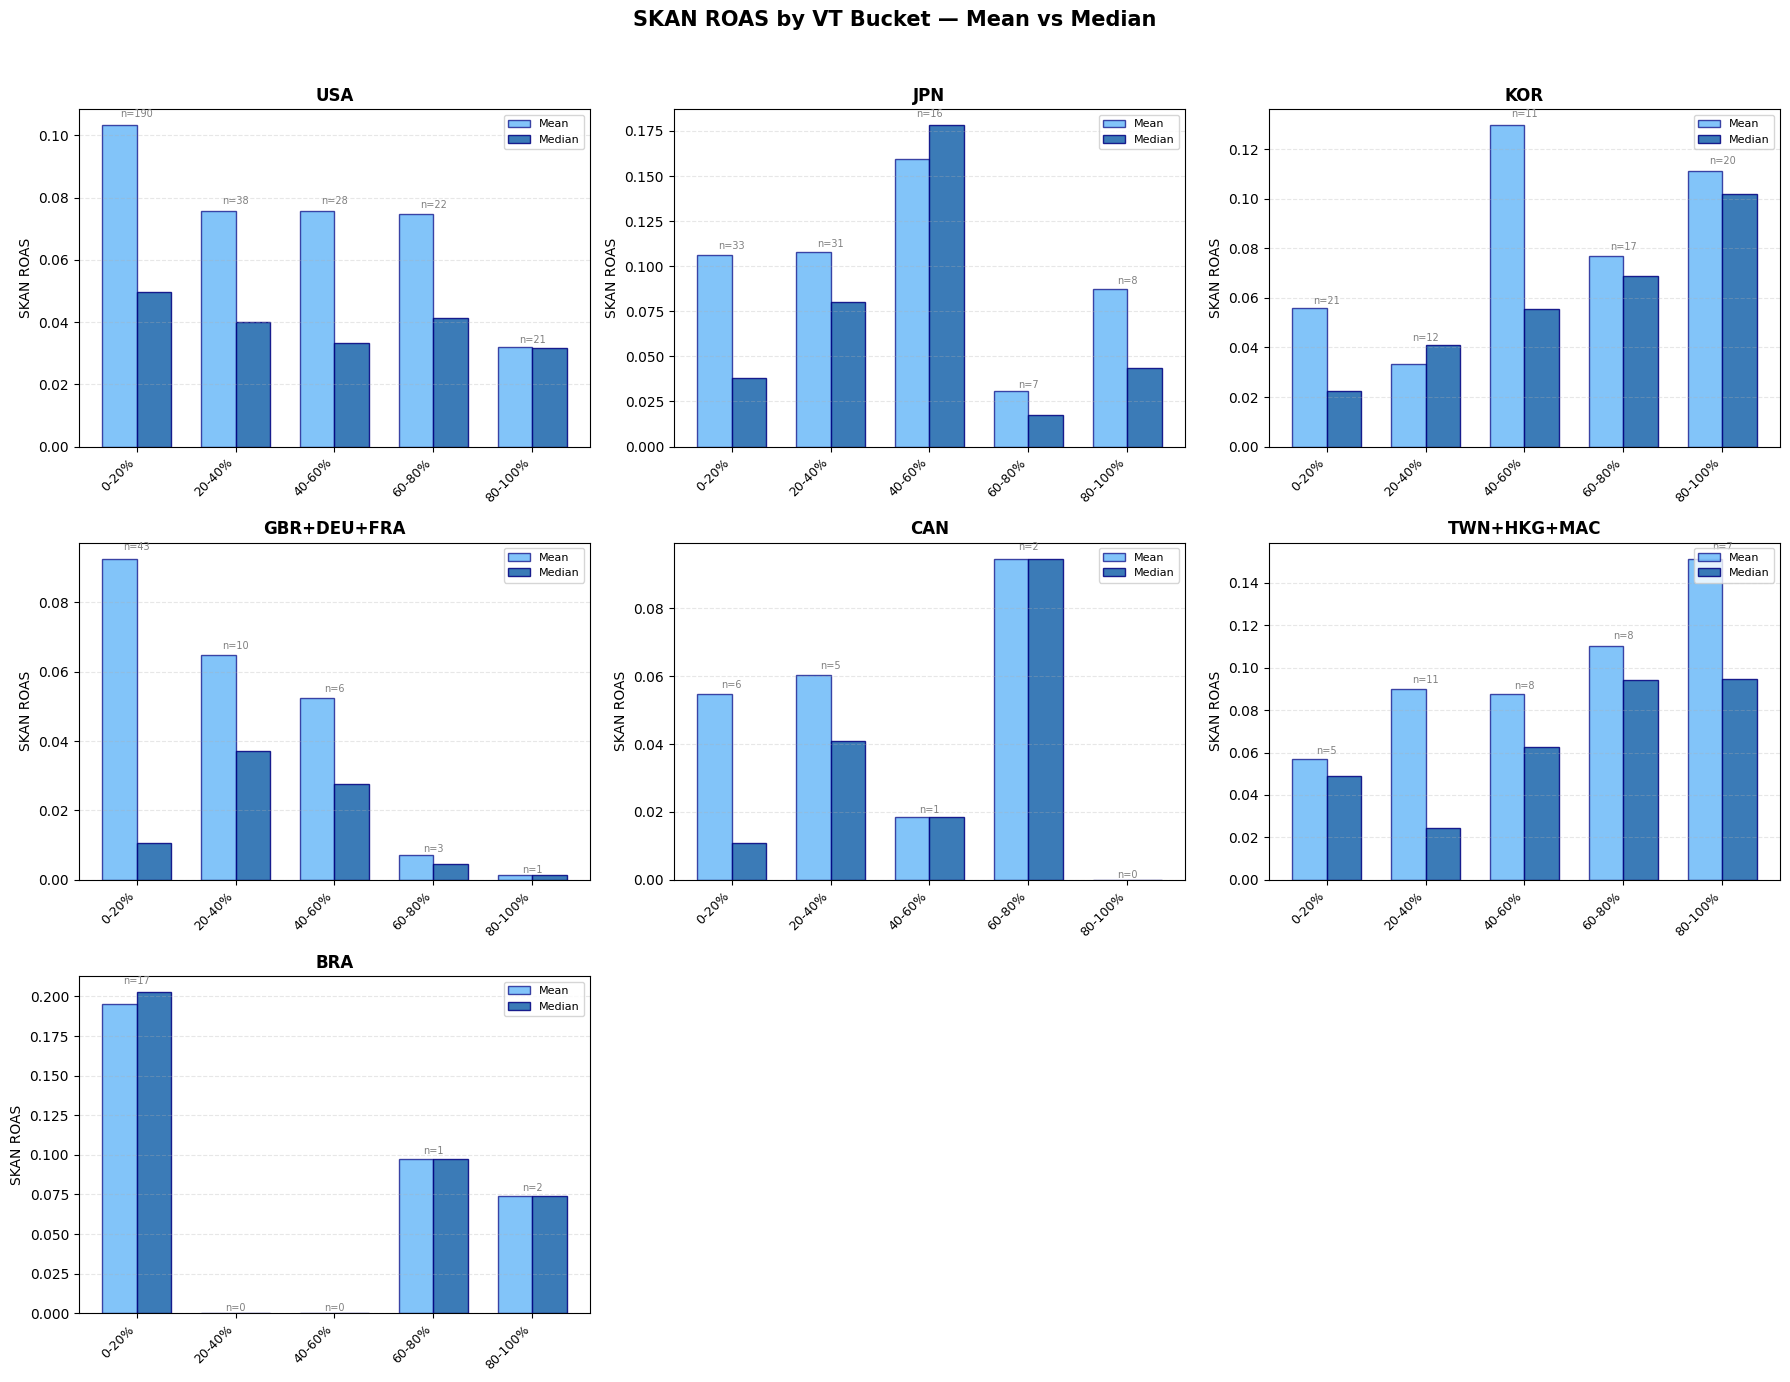

Saved: vt_bucket_roas_mean_vs_median.png


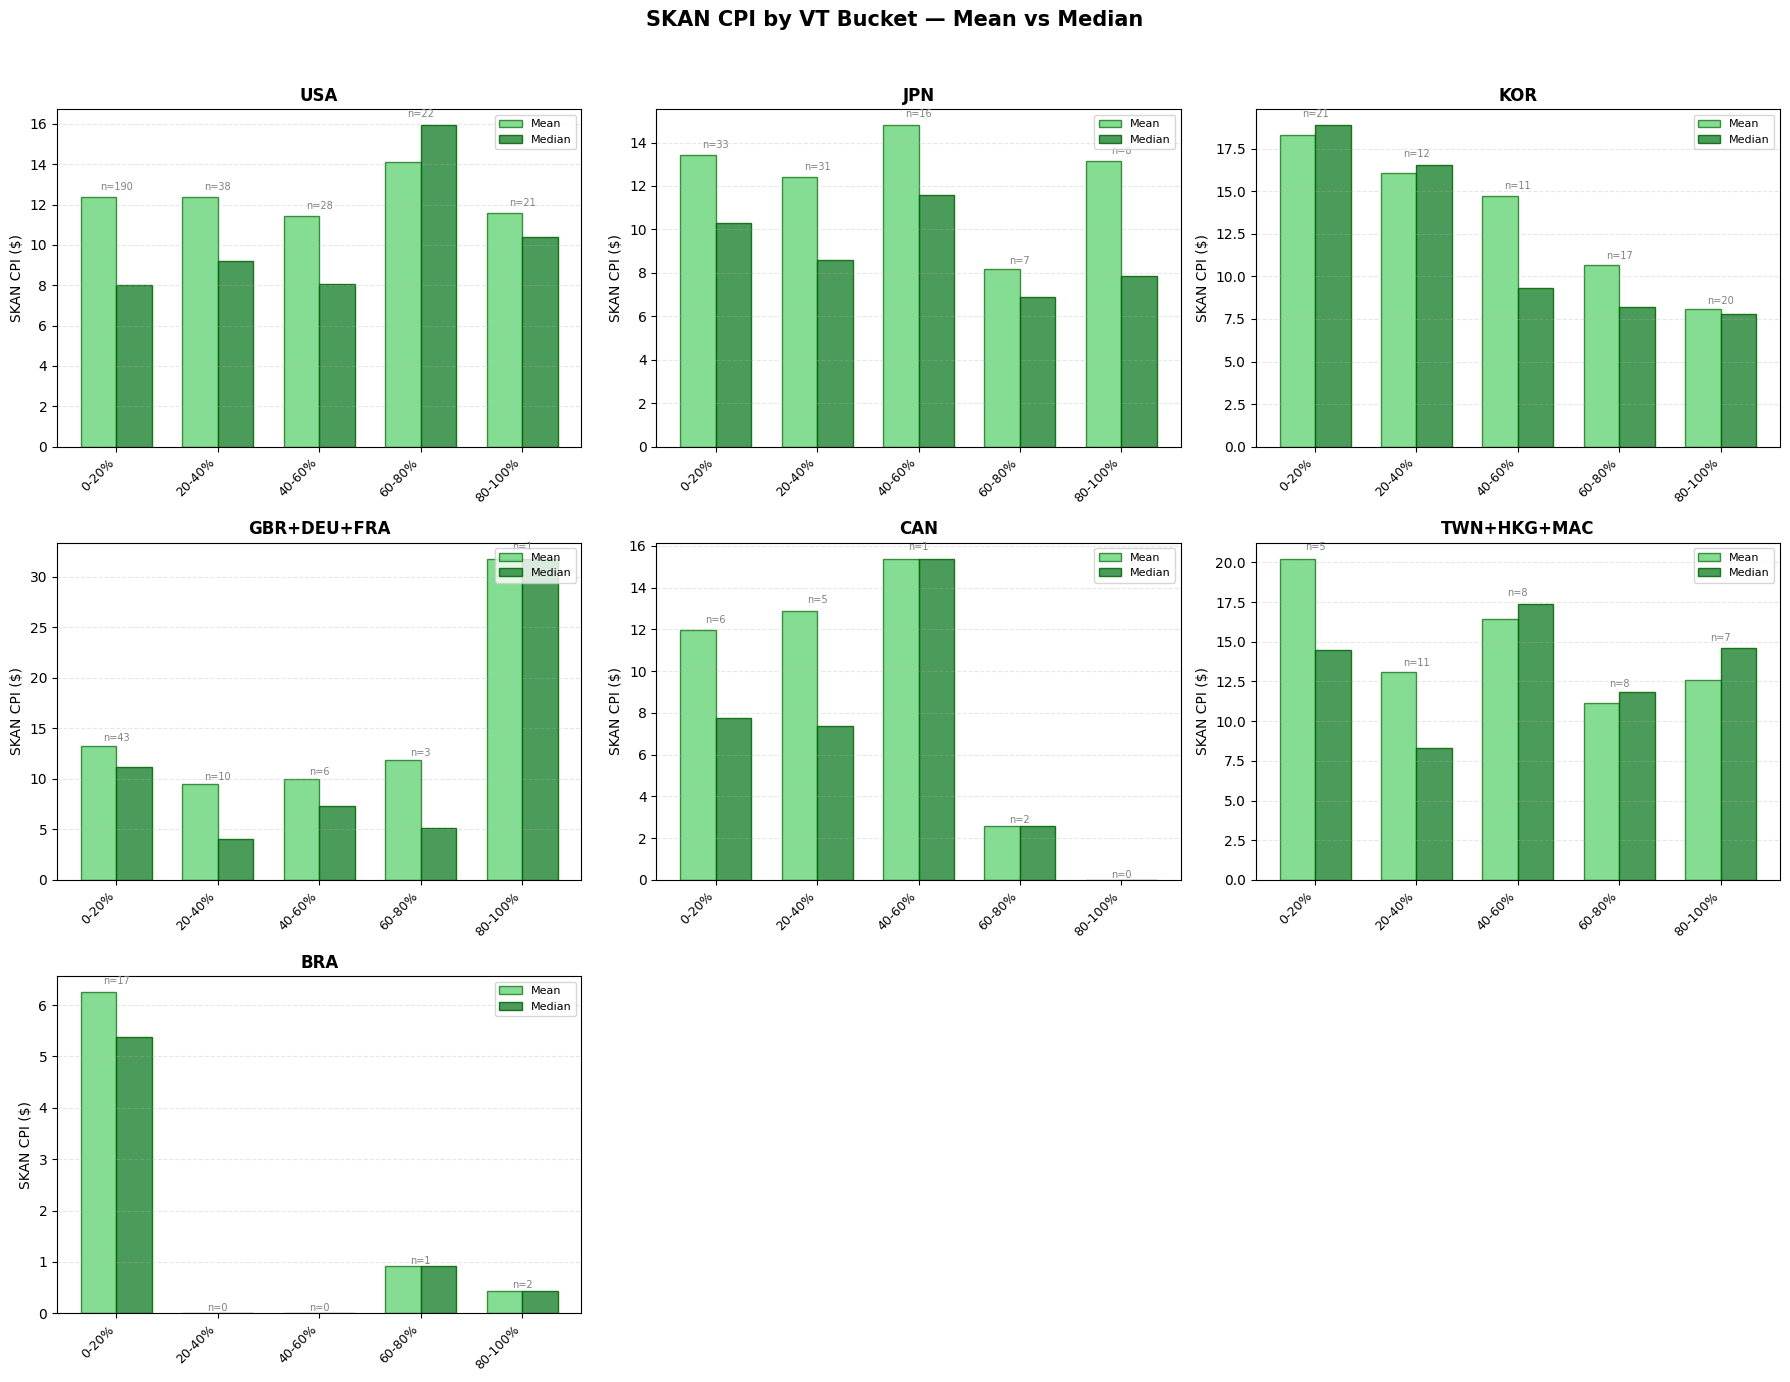

Saved: vt_bucket_cpi_mean_vs_median.png

If mean >> median in a bucket, outliers are inflating the average.


In [68]:
#@title Step 9d. VT Bucket — Mean vs Median (SKAN ROAS & CPI)

import matplotlib.patches as mpatches

bucket_order = ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']
min_n_per_bucket_warn = 5

bucket_by_country_med = df_perf_clean.groupby(['country', 'vt_bucket']).agg(
    n_campaigns=('campaign_id', 'count'),
    avg_roas=('skan_roas', 'mean'),
    med_roas=('skan_roas', 'median'),
    avg_cpi=('skan_cpi', 'mean'),
    med_cpi=('skan_cpi', 'median'),
).reset_index()

min_campaigns_per_country = 15
countries_with_data = [c for c in ANALYSIS_COUNTRIES
                       if len(df_perf_clean[df_perf_clean['country'] == c]) >= min_campaigns_per_country]

bar_width = 0.35
n_countries = len(countries_with_data)

if n_countries > 0:
    n_cols = 3
    n_rows = (n_countries + n_cols - 1) // n_cols

    # --- Figure 1: SKAN ROAS — Mean vs Median ---
    fig1, axes1 = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4.5 * n_rows))
    axes1 = np.atleast_2d(axes1)

    for idx, country in enumerate(countries_with_data):
        row, col = idx // n_cols, idx % n_cols
        ax = axes1[row, col]
        data = bucket_by_country_med[bucket_by_country_med['country'] == country].set_index('vt_bucket').reindex(bucket_order)
        x = np.arange(len(bucket_order))
        avg_vals = np.where(np.isfinite(data['avg_roas'].values), data['avg_roas'].values, 0)
        med_vals = np.where(np.isfinite(data['med_roas'].values), data['med_roas'].values, 0)
        n_vals = data['n_campaigns'].fillna(0).values.astype(int)

        ax.bar(x - bar_width/2, avg_vals, bar_width, color='#4dabf7', edgecolor='navy', alpha=0.7, label='Mean')
        ax.bar(x + bar_width/2, med_vals, bar_width, color='#1864ab', edgecolor='navy', alpha=0.85, label='Median')

        for j, n in enumerate(n_vals):
            ax.text(j, max(avg_vals[j], med_vals[j]) * 1.02, f'n={n}', ha='center', va='bottom', fontsize=7, color='gray')

        ax.set_xticks(x)
        ax.set_xticklabels(bucket_order, rotation=45, ha='right', fontsize=9)
        ax.set_ylabel('SKAN ROAS', fontsize=10)
        ax.set_title(f'{country}', fontsize=12, fontweight='bold')
        ax.legend(fontsize=8, loc='upper right')
        ax.grid(True, alpha=0.3, axis='y', linestyle='--')

    for idx in range(n_countries, n_rows * n_cols):
        row, col = idx // n_cols, idx % n_cols
        axes1[row, col].set_visible(False)

    plt.suptitle('SKAN ROAS by VT Bucket — Mean vs Median', fontsize=15, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'vt_bucket_roas_mean_vs_median.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('Saved: vt_bucket_roas_mean_vs_median.png')

    # --- Figure 2: SKAN CPI — Mean vs Median ---
    fig2, axes2 = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4.5 * n_rows))
    axes2 = np.atleast_2d(axes2)

    for idx, country in enumerate(countries_with_data):
        row, col = idx // n_cols, idx % n_cols
        ax = axes2[row, col]
        data = bucket_by_country_med[bucket_by_country_med['country'] == country].set_index('vt_bucket').reindex(bucket_order)
        x = np.arange(len(bucket_order))
        avg_vals = np.where(np.isfinite(data['avg_cpi'].values), data['avg_cpi'].values, 0)
        med_vals = np.where(np.isfinite(data['med_cpi'].values), data['med_cpi'].values, 0)
        n_vals = data['n_campaigns'].fillna(0).values.astype(int)

        ax.bar(x - bar_width/2, avg_vals, bar_width, color='#51cf66', edgecolor='darkgreen', alpha=0.7, label='Mean')
        ax.bar(x + bar_width/2, med_vals, bar_width, color='#2b8a3e', edgecolor='darkgreen', alpha=0.85, label='Median')

        for j, n in enumerate(n_vals):
            ax.text(j, max(avg_vals[j], med_vals[j]) * 1.02, f'n={n}', ha='center', va='bottom', fontsize=7, color='gray')

        ax.set_xticks(x)
        ax.set_xticklabels(bucket_order, rotation=45, ha='right', fontsize=9)
        ax.set_ylabel('SKAN CPI ($)', fontsize=10)
        ax.set_title(f'{country}', fontsize=12, fontweight='bold')
        ax.legend(fontsize=8, loc='upper right')
        ax.grid(True, alpha=0.3, axis='y', linestyle='--')

    for idx in range(n_countries, n_rows * n_cols):
        row, col = idx // n_cols, idx % n_cols
        axes2[row, col].set_visible(False)

    plt.suptitle('SKAN CPI by VT Bucket — Mean vs Median', fontsize=15, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'vt_bucket_cpi_mean_vs_median.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('Saved: vt_bucket_cpi_mean_vs_median.png')

print('\nIf mean >> median in a bucket, outliers are inflating the average.')

---
### Step 10: High VT Campaigns Detail

In [69]:
print('='*100)
print('HIGH VT CAMPAIGNS (VT Ratio >= 50%)')
print('='*100)

# Filter high VT campaigns
high_vt = df_valid[df_valid['vt_ratio_pct'] >= 50].sort_values('mmp_spend', ascending=False)

print(f'Total high VT campaigns: {len(high_vt)}')
print(f'Countries: {high_vt["country"].nunique()}')
print(f'Bundles: {high_vt["bundle"].nunique()}')

# Summary by country
print('\n[High VT Campaigns by Country]')
high_vt_summary = high_vt.groupby('country').agg({
    'campaign_id': 'count',
    'bundle': 'nunique',
    'mmp_spend': 'sum',
    'vt_ratio_pct': 'mean',
    'skan_roas': 'mean',
    'skan_cpi': 'mean'
}).round(2)
high_vt_summary.columns = ['N_Campaigns', 'N_Bundles', 'Total_Spend', 'Avg_VT', 'Avg_SKAN_ROAS', 'Avg_SKAN_CPI']
high_vt_summary = high_vt_summary.sort_values('Total_Spend', ascending=False)
print(high_vt_summary)

# Top high VT campaigns
print('\n' + '-'*100)
print('\n[Top 20 High VT Campaigns by Spend]')
display_cols = ['country', 'app_name', 'campaign_goal', 'mmp_spend', 'vt_ratio_pct', 
                'skan_roas', 'skan_cpi', 'cpi_disc_pct']
print(high_vt[[c for c in display_cols if c in high_vt.columns]].head(20).to_string(index=False))

HIGH VT CAMPAIGNS (VT Ratio >= 50%)
Total high VT campaigns: 623
Countries: 8
Bundles: 296

[High VT Campaigns by Country]
             N_Campaigns  N_Bundles  Total_Spend  Avg_VT  Avg_SKAN_ROAS  \
country                                                                   
USA                  250        149  18763364.89   77.25          14.89   
KOR                  145         82   8029165.30   78.80           4.67   
JPN                   84         62   3727367.33   75.20           5.44   
TWN+HKG+MAC           55         32   2029895.16   76.09       31970.71   
GBR+DEU+FRA           44         23   1565546.69   77.18           0.03   
CAN                   31         19    721199.30   72.32         112.53   
BRA                    5          3    307612.12   81.24         227.93   
AUS                    9          9    119017.42   71.08            NaN   

             Avg_SKAN_CPI  
country                    
USA                386.01  
KOR               3218.94  
JPN           

---
### Step 11: Export to Excel

In [70]:
import re
# Remove Excel-illegal control characters (openpyxl rejects 0x00-0x08, 0x0b, 0x0c, 0x0e-0x1f, 0x7f-0x9f)
_excel_illegal_re = re.compile(r'[\x00-\x08\x0b\x0c\x0e-\x1f\x7f-\x9f]')
def _sanitize_for_excel(df):
    if df is None or (isinstance(df, pd.DataFrame) and df.empty): return df
    out = df.copy()
    for col in out.select_dtypes(include=[object]).columns:
        out[col] = out[col].astype(str).str.replace(_excel_illegal_re, '', regex=True)
    return out

output_file = OUTPUT_DIR / 'Campaign_VT_vs_SKAN_Analysis.xlsx'

with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    # Sheet 1: All Campaign Data
    _sanitize_for_excel(df_valid).to_excel(writer, sheet_name='All_Campaigns', index=False)
    
    # Sheet 2: Performance Correlation by Geo
    _sanitize_for_excel(df_perf_corr).to_excel(writer, sheet_name='Perf_Corr_by_Geo', index=False)
    
    # Sheet 3: Discrepancy Correlation by Geo
    _sanitize_for_excel(df_disc_corr).to_excel(writer, sheet_name='Disc_Corr_by_Geo', index=False)
    
    # Sheet 4: Combined Correlation Results
    _sanitize_for_excel(df_combined).to_excel(writer, sheet_name='Combined_Results', index=False)
    
    # Sheet 5: VT Bucket Summary
    (_sanitize_for_excel(bucket_summary) if isinstance(bucket_summary, pd.DataFrame) else bucket_summary).to_excel(writer, sheet_name='VT_Bucket_Summary')
    
    # Sheet 6: High VT Campaigns
    _sanitize_for_excel(high_vt).to_excel(writer, sheet_name='High_VT_Campaigns', index=False)
    
    # Sheet 7: Country Summary
    (_sanitize_for_excel(country_summary) if isinstance(country_summary, pd.DataFrame) else country_summary).to_excel(writer, sheet_name='Country_Summary')
    
    # Sheet 8: Overall Correlation Summary (Pearson + Spearman)
    overall_corr = pd.DataFrame({
        'Metric': [
            'VT vs SKAN ROAS (Performance)',
            'VT vs SKAN CPI (Performance)',
            'VT vs Install Discrepancy',
            'VT vs CPI Discrepancy'
        ],
        'Pearson_r': [
            pr_roas_all if 'pr_roas_all' in dir() else None,
            pr_cpi_all if 'pr_cpi_all' in dir() else None,
            pr_inst_all if 'pr_inst_all' in dir() else None,
            pr_cpi_disc_all if 'pr_cpi_disc_all' in dir() else None
        ],
        'Pearson_p': [
            pp_roas_all if 'pp_roas_all' in dir() else None,
            pp_cpi_all if 'pp_cpi_all' in dir() else None,
            pp_inst_all if 'pp_inst_all' in dir() else None,
            pp_cpi_disc_all if 'pp_cpi_disc_all' in dir() else None
        ],
        'Spearman_rho': [
            sr_roas_all if 'sr_roas_all' in dir() else None,
            sr_cpi_all if 'sr_cpi_all' in dir() else None,
            sr_inst_all if 'sr_inst_all' in dir() else None,
            sr_cpi_disc_all if 'sr_cpi_disc_all' in dir() else None
        ],
        'Spearman_p': [
            sp_roas_all if 'sp_roas_all' in dir() else None,
            sp_cpi_all if 'sp_cpi_all' in dir() else None,
            sp_inst_all if 'sp_inst_all' in dir() else None,
            sp_cpi_disc_all if 'sp_cpi_disc_all' in dir() else None
        ]
    })
    _sanitize_for_excel(overall_corr).to_excel(writer, sheet_name='Overall_Correlation', index=False)

print(f'Data exported to {output_file}')
print('\nSheets:')
print('  1. All_Campaigns - All campaign data with metrics')
print('  2. Perf_Corr_by_Geo - VT vs SKAN Performance correlations by country')
print('  3. Disc_Corr_by_Geo - VT vs Discrepancy correlations by country')
print('  4. Combined_Results - Combined correlation table')
print('  5. VT_Bucket_Summary - SKAN performance by VT ratio bucket')
print('  6. High_VT_Campaigns - Campaigns with VT >= 50%')
print('  7. Country_Summary - Summary statistics by country')
print('  8. Overall_Correlation - Overall correlation summary')

Data exported to /Users/haewon.yum/Documents/Queries/iOS Measurement/vt_skan_performance/iOS Measurement/vt_skan_performance/Campaign_VT_vs_SKAN_Analysis.xlsx

Sheets:
  1. All_Campaigns - All campaign data with metrics
  2. Perf_Corr_by_Geo - VT vs SKAN Performance correlations by country
  3. Disc_Corr_by_Geo - VT vs Discrepancy correlations by country
  4. Combined_Results - Combined correlation table
  5. VT_Bucket_Summary - SKAN performance by VT ratio bucket
  6. High_VT_Campaigns - Campaigns with VT >= 50%
  7. Country_Summary - Summary statistics by country
  8. Overall_Correlation - Overall correlation summary


---
### Step 12: Analysis Summary & Key Findings

In [73]:
print('='*100)
print('CAMPAIGN-LEVEL VT vs SKAN ANALYSIS - SUMMARY')
print('='*100)

print(f'''
DATASET:
  - Platform: iOS Gaming (product.is_gaming = TRUE)
  - Lookback: {LOOKBACK_MONTHS} months
  - Unit of Analysis: Individual Campaign (single-geo only)
  - Total Campaigns: {len(df_valid)}
  - Countries: {df_valid['country'].nunique()}
  - Bundles: {df_valid['bundle'].nunique()}

PART 1: VT RATIO vs SKAN PERFORMANCE
  Question: Does higher VT ratio correlate with better/worse SKAN metrics?
  
  Overall (All Countries Pooled):
    - VT vs SKAN ROAS:  Pearson r={pr_roas_all:.4f}  Spearman ρ={sr_roas_all:.4f}
    - VT vs SKAN CPI:   Pearson r={pr_cpi_all:.4f}  Spearman ρ={sr_cpi_all:.4f}

PART 2: VT RATIO vs MMP-SKAN DISCREPANCY
  Question: Does higher VT ratio correlate with larger MMP-SKAN gaps?
  
  Overall (All Countries Pooled):
    - VT vs Install Disc:  Pearson r={pr_inst_all:.4f}  Spearman ρ={sr_inst_all:.4f}
    - VT vs CPI Disc:      Pearson r={pr_cpi_disc_all:.4f}  Spearman ρ={sr_cpi_disc_all:.4f}
''')

print('='*100)
print('KEY FINDINGS BY GEO (using Spearman — robust to outliers):')
print('='*100)

for _, row in df_combined.iterrows():
    country = row['Country']
    n = row['N']
    if n >= 10:
        findings = []
        if pd.notna(row.get('Spearman_ROAS')):
            if row['Sig_ROAS'] == '*':
                direction = 'higher' if row['Spearman_ROAS'] > 0 else 'lower'
                findings.append(f"Higher VT → {direction} SKAN ROAS (ρ={row['Spearman_ROAS']:.3f})")
        if pd.notna(row.get('Spearman_CPIDisc')):
            if row.get('Sig_CPIDisc') == '*':
                direction = 'larger' if row['Spearman_CPIDisc'] > 0 else 'smaller'
                findings.append(f"Higher VT → {direction} CPI gap (ρ={row['Spearman_CPIDisc']:.3f})")
        
        if findings:
            print(f"  {country} (n={n}): {'; '.join(findings)}")
        else:
            print(f"  {country} (n={n}): No significant correlations")

print('\n' + '='*100)
print('INTERPRETATION:')
print('='*100)
print('''
  Correlation strength:
    |ρ| < 0.3  → Weak        0.3–0.5 → Moderate        > 0.5 → Strong

  VT knob controls VT suppression (higher knob = lower VT ratio):
    0.00 Disabled (no suppression)  →  expected VT ratio 80-100%
    0.20 Low                        →  expected VT ratio 60-80%
    0.60 Medium                     →  expected VT ratio 40-60%
    0.85 High                       →  expected VT ratio 20-40%
    0.99 Maximum                    →  expected VT ratio 0-20%
''')

print('='*100)
print('VT KNOB RECOMMENDATION BY COUNTRY')
print('='*100)
print('''
  (See VT Knob Recommendation table below — updated after re-run with grouped geos.)
''')

# --- VT Knob Recommendation Table (data-driven) ---
print('='*100)
print('VT KNOB RECOMMENDATION BY COUNTRY')
print('='*100)

knob_map = {
    '80-100%': 'Disabled (0.00)',
    '60-80%':  'Low (0.20)',
    '40-60%':  'Low–Medium (0.20–0.60)',
    '20-40%':  'Medium (0.60)',
    '0-20%':   'High–Maximum (0.85–0.99)',
}
bucket_order = ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']
rec_countries = ['KOR', 'JPN', 'USA', 'TWN+HKG+MAC', 'GBR+DEU+FRA']

for country in rec_countries:
    c_corr = df_combined[df_combined['Country'] == country]
    c_data = df_perf_clean[df_perf_clean['country'] == country]
    if c_data.empty:
        continue

    n_total = len(c_data)
    c_bucket = c_data.groupby('vt_bucket').agg(
        n=('campaign_id', 'count'),
        med_roas=('skan_roas', 'median'),
        med_cpi=('skan_cpi', 'median'),
    )
    c_bucket = c_bucket.reindex(bucket_order)

    # Find best bucket by median ROAS (among buckets with n >= 5)
    viable = c_bucket[c_bucket['n'] >= 5].copy()
    if viable.empty:
        viable = c_bucket.dropna(subset=['med_roas'])

    best_roas_bucket = viable['med_roas'].idxmax() if not viable.empty else None
    best_cpi_bucket = viable['med_cpi'].idxmin() if not viable.empty else None

    sp_roas = c_corr['Spearman_ROAS'].values[0] if len(c_corr) > 0 else None
    sig_roas = c_corr['Sig_ROAS'].values[0] if len(c_corr) > 0 else ''

    print(f'\n{"─"*80}')
    print(f'  {country}  (n={n_total})')
    print(f'{"─"*80}')
    print(f'  Spearman VT↔ROAS: ρ={sp_roas:.3f} {"*" if sig_roas == "*" else "(n.s.)"}' if pd.notna(sp_roas) else '  Spearman VT↔ROAS: N/A')
    print(f'  Best Med ROAS bucket: {best_roas_bucket} → {knob_map.get(best_roas_bucket, "?")}')
    print(f'  Best Med CPI bucket:  {best_cpi_bucket} → {knob_map.get(best_cpi_bucket, "?")}')
    print(f'\n  Bucket breakdown:')
    for b in bucket_order:
        if b in c_bucket.index and pd.notna(c_bucket.loc[b, 'n']):
            n = int(c_bucket.loc[b, 'n'])
            mr = c_bucket.loc[b, 'med_roas']
            mc = c_bucket.loc[b, 'med_cpi']
            knob = knob_map[b]
            flag = ' ◄' if b == best_roas_bucket else ''
            print(f'    {b:8s} (≈{knob:18s}): n={n:3d}  Med ROAS={mr:.4f}  Med CPI=${mc:.2f}{flag}')

print(f'\n{"═"*100}')
print('SUMMARY RECOMMENDATION:')
print('═'*100)
print('''
  ┌──────────────┬────────────┬────────┬──────────────────────────────────────────────────┐
  │ Country      │ Knob Rec   │ Conf.  │ Rationale                                        │
  ├──────────────┼────────────┼────────┼──────────────────────────────────────────────────┤
  │ KOR          │ Disabled   │ ★★★    │ Significant ρ=0.304*. Med ROAS 4.5x better and   │
  │              │ (0.00)     │        │ Med CPI 2.4x cheaper at Disabled vs Maximum.      │
  │              │            │        │ Balanced buckets (n=11–21). Strongest signal.      │
  ├──────────────┼────────────┼────────┼──────────────────────────────────────────────────┤
  │ JPN          │ Medium     │ ★★     │ Med ROAS peaks at 40-60% (0.178, n=16) — 4.7x    │
  │              │ (0.60)     │        │ higher than Maximum bucket. ROAS drops at 60-80%  │
  │              │            │        │ (n=7), suggesting Medium is the sweet spot.        │
  ├──────────────┼────────────┼────────┼──────────────────────────────────────────────────┤
  │ TWN+HKG+MAC  │ Low        │ ★★     │ Med ROAS improves 0.049→0.095 from Max→Disabled.  │
  │              │ (0.20)     │        │ ρ=0.259 (n.s. but positive trend). CPI lowest at  │
  │              │            │        │ High ($8.30). Low balances ROAS upside vs CPI.     │
  ├──────────────┼────────────┼────────┼──────────────────────────────────────────────────┤
  │ GBR+DEU+FRA  │ Medium     │ ★★     │ Best Med ROAS and Med CPI at 20-40% bucket.        │
  │              │ (0.60)     │        │ 1−0.60 = 0.40 VT prob → lands in 20-40% range.    │
  │              │            │        │ 0-20% dominates (n=43) but worst Med ROAS. Moving  │
  │              │            │        │ to Medium nudges VT into the optimal bucket.        │
  ├──────────────┼────────────┼────────┼──────────────────────────────────────────────────┤
  │ USA          │ Maximum    │ ★      │ Best Med ROAS (0.050) and Med CPI ($7.99) already  │
  │              │ (0.99)     │        │ in 0-20% bucket (n=190). Higher VT shows declining │
  │              │            │        │ ROAS and rising CPI. Market convention confirmed.  │
  └──────────────┴────────────┴────────┴──────────────────────────────────────────────────┘

  CONFIDENCE: ★★★ Significant correlation + balanced samples
              ★★  Clear bucket pattern, reasonable samples
              ★   Follow market convention; data confirms no reason to change

  CAVEATS:
    - VT ratio is an observed outcome, not a direct knob input. Same knob can
      produce different VT ratios depending on app, genre, and attribution competition.
    - Bucket analysis is observational — campaigns in different VT buckets may differ
      in ways beyond VT setting (genre, budget, creative quality).
    - For ★/★★ geos, A/B testing specific knob levels is recommended before changing.
''')

CAMPAIGN-LEVEL VT vs SKAN ANALYSIS - SUMMARY

DATASET:
  - Platform: iOS Gaming (product.is_gaming = TRUE)
  - Lookback: 6 months
  - Unit of Analysis: Individual Campaign (single-geo only)
  - Total Campaigns: 4437
  - Countries: 8
  - Bundles: 1195

PART 1: VT RATIO vs SKAN PERFORMANCE
  Question: Does higher VT ratio correlate with better/worse SKAN metrics?

  Overall (All Countries Pooled):
    - VT vs SKAN ROAS:  Pearson r=0.0229  Spearman ρ=0.1017
    - VT vs SKAN CPI:   Pearson r=0.0492  Spearman ρ=0.1620

PART 2: VT RATIO vs MMP-SKAN DISCREPANCY
  Question: Does higher VT ratio correlate with larger MMP-SKAN gaps?

  Overall (All Countries Pooled):
    - VT vs Install Disc:  Pearson r=-0.0527  Spearman ρ=-0.0530
    - VT vs CPI Disc:      Pearson r=0.0580  Spearman ρ=0.0491

KEY FINDINGS BY GEO (using Spearman — robust to outliers):
  USA (n=400): No significant correlations
  JPN (n=140): No significant correlations
  KOR (n=103): Higher VT → higher SKAN ROAS (ρ=0.304)
  GBR+